# import

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

In [2]:
import time, io
from tqdm import tqdm
import tensorflow as tf
import sklearn
from PIL import Image
import numpy as np
import pickle
from cleverhans import utils_tf
from util import cvt2Image, sparse_tuple_from

In [3]:
def invert(data): # 反色
    if data.max() < 1.5:
        return 1 - data
    else:
        return 255 - data

def transpose(data): # 旋转90度
    if len(data.shape) != 2:
        return np.swapaxes(data, 1, 2)
    else:
        return data.T

def cvt2raw(data):
    return transpose(invert(data))

def show(img):
    return cvt2Image(cvt2raw(img))

In [4]:
from skimage.measure import compare_ssim, compare_mse, compare_psnr
def pert_eval(image0, image1):
    return compare_mse(image0, image1), compare_psnr(image0, image1), compare_ssim(image0, image1)

def get_text_mask(img: np.array):
    if img.max() <= 1:
        return img < 1 / 1.25
    else:
        return img < 255 / 1.25

def wm_pert_eval(raw_img, adv_img):
    text_mask = get_text_mask(raw_img)
    mse_text = compare_mse(raw_img * text_mask, adv_img * text_mask)
    bg_mask = ~text_mask
    mse_bg = compare_mse(raw_img * bg_mask, adv_img * bg_mask)
    pixel_text = np.sum(text_mask)
    pixel_bg = np.sum(bg_mask)
    pixel_total = pixel_text + pixel_bg
    return pixel_text / pixel_total * mse_text + pixel_bg / pixel_total * mse_bg, mse_text, mse_bg

In [5]:
def asr_eval(adv_text, target_text, gt_text):
    t_cnt, u_cnt, f_cnt = 0, 0, 0 # target, untarget, fail
    for adv_t, target_t, gt_t in zip(adv_text, target_text, gt_text):
        if adv_t == target_t:
            t_cnt += 1
        elif adv_t != gt_t:
            u_cnt += 1
        else:
            f_cnt += 1
    total = len(adv_text)
    # t_asr, u_asr, f_r
    return t_cnt/total, (t_cnt + u_cnt)/total, f_cnt/total

In [6]:
def iter_eval(record_iter, duration):
    avg_success_iter = np.mean(record_iter[record_iter != 0]) 
    total_iter = np.max(record_iter)
    avg_iter_time = duration / total_iter
    return avg_success_iter, avg_iter_time

# Attack Setting

In [7]:
# fixed setting
clip_min, clip_max = 0.0, 1.0
eps = 0.2
batch_size = 100
nb_iter = 1000

In [8]:
# only change once in one experiment
pert_type = '2'
eps_iter = 5.0

In [9]:
# traverse all of them
cases = ['easy', 'random', 'hard']
fonts = ['Courier','Georgia','Helvetica','times','Arial','Courierbd','Georgiabd','Helveticabd','timesbd','Arialbd']

In [10]:
# word image data
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/word_image_data'

In [11]:
with open(f'{img_data_path}/intersect_word.pkl', 'rb') as f:
    intersect_word = pickle.load(f)
intersect_word = set(intersect_word)

In [12]:
def filter_word(input_img, adv_img, gt_txt, target_txt, record_adv_text, record_iter):
    new_input_img, new_adv_img, new_gt_txt, new_target_txt, new_record_adv_text, new_record_iter = [], [], [], [], [], []
    for i, gt in enumerate(gt_txt):
        if gt in intersect_word:
            new_input_img.append(input_img[i])
            new_adv_img.append(adv_img[i])
            new_gt_txt.append(gt_txt[i])
            new_target_txt.append(target_txt[i])
            new_record_adv_text.append(record_adv_text[i])
            new_record_iter.append(record_iter[i])
    return np.asarray(new_input_img), np.asarray(new_adv_img), \
            new_gt_txt, new_target_txt, new_record_adv_text, new_record_iter

# Cross Entropy vs CTC loss

# L2 vs Linf

In [21]:
case = 'easy'

In [22]:
pert_type = '2'
eps_iter = 5.0

In [23]:
for font_name in fonts[5:]:
    with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
        img_list, input_img, len_x, gt_txt, target_txt = pickle.load(f)
    input_img = np.asarray(input_img)
    title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
    with open(f'attack_result/{title}.pkl', 'rb') as f:
        adv_img, record_adv_text, record_iter, (duration, total_iter) = pickle.load(f)
    input_img, adv_img, gt_txt, target_txt, record_adv_text, record_iter = \
                    filter_word(input_img, adv_img, gt_txt, target_txt, record_adv_text, record_iter)
    print(f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter} {len(adv_img)} examples")
    input_img = (255 * cvt2raw(input_img)).astype('uint8')
    adv_img = (255 * cvt2raw(adv_img)).astype('uint8')
    
    mse, psnr, ssim = pert_eval(adv_img, input_img)
    print(f"mse-{mse:.3f} psnr-{psnr:.3f} ssim-{ssim:.3f}")
    wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)
    print(f"wm_mse-{wm_mse:.3f} bg_mse-{bg_mse:.3f} text_mse-{text_mse:.3f}")
    t_asr, u_asr, fail_r = asr_eval(record_adv_text, target_txt, gt_txt)
    print(f"t_asr-{100*t_asr:.3f} u_asr-{100*u_asr:.3f} fail_r-{100*fail_r:.3f}")
    avg_success_iter, avg_iter_time = iter_eval(record_iter, duration)
    print(f"avg_success_iter-{avg_success_iter:.3f} avg_iter_time-{avg_iter_time:.3f}")
    print("-" * 60)

Courierbd-easy-l2-eps0.2-ieps5.0-iter1000 3481 examples
mse-23.564 psnr-34.408 ssim-0.977
wm_mse-11.292 bg_mse-12.415 text_mse-11.149
t_asr-100.000 u_asr-100.000 fail_r-0.000
avg_success_iter-69.000 avg_iter_time-3.657
------------------------------------------------------------
Georgiabd-easy-l2-eps0.2-ieps5.0-iter1000 3481 examples
mse-25.926 psnr-33.993 ssim-0.975
wm_mse-12.263 bg_mse-13.861 text_mse-12.065
t_asr-100.000 u_asr-100.000 fail_r-0.000
avg_success_iter-59.000 avg_iter_time-3.803
------------------------------------------------------------
Helveticabd-easy-l2-eps0.2-ieps5.0-iter1000 3481 examples
mse-32.781 psnr-32.975 ssim-0.970
wm_mse-14.980 bg_mse-18.272 text_mse-14.509
t_asr-100.000 u_asr-100.000 fail_r-0.000
avg_success_iter-75.000 avg_iter_time-4.001
------------------------------------------------------------
timesbd-easy-l2-eps0.2-ieps5.0-iter1000 3481 examples
mse-26.304 psnr-33.931 ssim-0.975
wm_mse-12.629 bg_mse-13.810 text_mse-12.494
t_asr-100.000 u_asr-100.00

Courier-easy-l2-eps0.2-ieps5.0-iter1000 3481 examples
mse-10.549 psnr-37.899 ssim-0.988
wm_mse-6.153 bg_mse-4.270 text_mse-6.279
t_asr-100.000 u_asr-100.000 fail_r-0.000
avg_success_iter-59.000 avg_iter_time-3.791

Georgia-easy-l2-eps0.2-ieps5.0-iter1000 3481 examples
mse-27.432 psnr-33.748 ssim-0.974
wm_mse-13.659 bg_mse-13.785 text_mse-13.647
t_asr-100.000 u_asr-100.000 fail_r-0.000
avg_success_iter-43.000 avg_iter_time-4.504

Helvetica-easy-l2-eps0.2-ieps5.0-iter1000 3481 examples
mse-27.024 psnr-33.813 ssim-0.975
wm_mse-13.495 bg_mse-13.533 text_mse-13.491
t_asr-100.000 u_asr-100.000 fail_r-0.000
avg_success_iter-51.000 avg_iter_time-4.574

times-easy-l2-eps0.2-ieps5.0-iter1000 3481 examples
mse-26.421 psnr-33.911 ssim-0.975
wm_mse-13.337 bg_mse-13.060 text_mse-13.361
t_asr-100.000 u_asr-100.000 fail_r-0.000
avg_success_iter-62.000 avg_iter_time-7.427

Arial-easy-l2-eps0.2-ieps5.0-iter1000 3481 examples
mse-29.806 psnr-33.388 ssim-0.972
wm_mse-14.758 bg_mse-15.083 text_mse-14.723
t_asr-100.000 u_asr-100.000 fail_r-0.000
avg_success_iter-51.000 avg_iter_time-4.490


## Linf

In [17]:
pert_type = 'inf'
eps_iter = 1.0

In [19]:
for font_name in fonts[:5]:
    with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
        img_list, input_img, len_x, gt_txt, target_txt = pickle.load(f)
    input_img = np.asarray(input_img)
    title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
    with open(f'attack_result/{title}.pkl', 'rb') as f:
        adv_img, record_adv_text, record_iter, (duration, total_iter) = pickle.load(f)
    print(f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter} {len(adv_img)} examples")
    
    input_img = (255 * cvt2raw(input_img)).astype('uint8')
    adv_img = (255 * cvt2raw(adv_img)).astype('uint8')
    
    mse, psnr, ssim = pert_eval(adv_img, input_img)
    print(f"mse-{mse:.3f} psnr-{psnr:.3f} ssim-{ssim:.3f}")
    wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)
    print(f"wm_mse-{wm_mse:.3f} bg_mse-{bg_mse:.3f} text_mse-{text_mse:.3f}")
    t_asr, u_asr, fail_r = asr_eval(record_adv_text, target_txt, gt_txt)
    print(f"t_asr-{100*t_asr:.3f} u_asr-{100*u_asr:.3f} fail_r-{100*fail_r:.3f}")
    avg_success_iter, avg_iter_time = iter_eval(record_iter, duration)
    print(f"avg_success_iter-{avg_success_iter:.3f} avg_iter_time-{avg_iter_time:.3f}")
    print("-" * 60)

Courier-easy-linf-eps0.2-ieps1.0-iter1000 3532 examples
mse-72.397 psnr-29.534 ssim-0.771
wm_mse-60.325 bg_mse-8.625 text_mse-63.771
t_asr-100.000 u_asr-100.000 fail_r-0.000
avg_success_iter-8.071 avg_iter_time-4.154
------------------------------------------------------------
Georgia-easy-linf-eps0.2-ieps1.0-iter1000 4868 examples
mse-160.267 psnr-26.082 ssim-0.645
wm_mse-123.257 bg_mse-27.935 text_mse-132.332
t_asr-100.000 u_asr-100.000 fail_r-0.000
avg_success_iter-12.789 avg_iter_time-4.955
------------------------------------------------------------
Helvetica-easy-linf-eps0.2-ieps1.0-iter1000 4842 examples
mse-157.511 psnr-26.158 ssim-0.658
wm_mse-118.845 bg_mse-29.197 text_mse-128.314
t_asr-100.000 u_asr-100.000 fail_r-0.000
avg_success_iter-12.618 avg_iter_time-4.744
------------------------------------------------------------
times-easy-linf-eps0.2-ieps1.0-iter1000 4887 examples
mse-153.695 psnr-26.264 ssim-0.653
wm_mse-118.706 bg_mse-26.421 text_mse-127.274
t_asr-100.000 u_asr

## LaTeX

In [14]:
latex_line = ''
for font_name in tqdm(fonts):
    with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
        _, raw_input_img, raw_len_x, raw_gt_txt, raw_target_txt = pickle.load(f)
    raw_input_img = np.asarray(raw_input_img)
    latex_line += f'{font_name[0].upper() + font_name[1:]}'
    for pert_type, eps_iter in [('2', 5.0), ('inf', 1.0)]:
        title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
        with open(f'attack_result/{title}.pkl', 'rb') as f:
            adv_img, record_adv_text, record_iter, (duration, total_iter) = pickle.load(f)
        input_img, adv_img, gt_txt, target_txt, record_adv_text, record_iter = \
                        filter_word(raw_input_img, adv_img, raw_gt_txt, raw_target_txt, record_adv_text, record_iter)
        input_img = (255 * cvt2raw(input_img)).astype('uint8')
        adv_img = (255 * cvt2raw(adv_img)).astype('uint8')

        mse, psnr, ssim = pert_eval(adv_img, input_img)
        wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)
        t_asr, u_asr, fail_r = asr_eval(record_adv_text, target_txt, gt_txt)
        avg_success_iter, avg_iter_time = iter_eval(record_iter, duration)
        latex_line += f' & {mse:.1f} & {psnr:.1f} & {ssim:.1f} & {t_asr:.1f} & {avg_success_iter:.1f} & {avg_iter_time:.1f}'
    latex_line += ' \\\\ \n'
print(latex_line)

Courier & 10.5 & 37.9 & 1.0 & 1.0 & 59.0 & 3.8 & 72.6 & 29.5 & 0.8 & 1.0 & 11.0 & 4.2 \\ 
Georgia & 27.4 & 33.7 & 1.0 & 1.0 & 43.0 & 4.5 & 163.6 & 26.0 & 0.6 & 1.0 & 11.0 & 10.3 \\ 
Helvetica & 27.0 & 33.8 & 1.0 & 1.0 & 51.0 & 4.6 & 159.4 & 26.1 & 0.6 & 1.0 & 10.0 & 4.7 \\ 
Times & 26.4 & 33.9 & 1.0 & 1.0 & 62.0 & 7.4 & 156.6 & 26.2 & 0.6 & 1.0 & 11.0 & 5.3 \\ 
Arial & 29.8 & 33.4 & 1.0 & 1.0 & 51.0 & 4.5 & 169.3 & 25.8 & 0.6 & 1.0 & 11.0 & 4.7 \\ 
Courierbd & 23.6 & 34.4 & 1.0 & 1.0 & 69.0 & 3.7 & 134.7 & 26.8 & 0.7 & 1.0 & 12.0 & 7.2 \\ 
Georgiabd & 25.9 & 34.0 & 1.0 & 1.0 & 59.0 & 3.8 & 161.3 & 26.1 & 0.6 & 1.0 & 11.0 & 4.4 \\ 
Helveticabd & 32.8 & 33.0 & 1.0 & 1.0 & 75.0 & 4.0 & 190.7 & 25.3 & 0.6 & 1.0 & 14.0 & 3.6 \\ 
Timesbd & 26.3 & 33.9 & 1.0 & 1.0 & 26.0 & 3.6 & 160.1 & 26.1 & 0.6 & 1.0 & 6.0 & 5.2 \\ 
Arialbd & 34.2 & 32.8 & 1.0 & 1.0 & 69.0 & 3.4 & 197.7 & 25.2 & 0.6 & 1.0 & 13.0 & 5.6 \\ 
 \hline


# font type

# attack difficulty

In [19]:
pert_type = '2'
eps_iter = 5.0

In [ ]:
for font_name in fonts:
    for case in cases:
        with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
            img_list, input_img, len_x, gt_txt, target_txt = pickle.load(f)
        input_img = np.asarray(input_img)
        title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
        with open(f'attack_result/{title}.pkl', 'rb') as f:
            adv_img, record_adv_text, record_iter, (duration, total_iter) = pickle.load(f)
        print(f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter} {len(adv_img)} examples")

        input_img = (255 * cvt2raw(input_img)).astype('uint8')
        adv_img = (255 * cvt2raw(adv_img)).astype('uint8')

        mse, psnr, ssim = pert_eval(adv_img, input_img)
        print(f"mse-{mse:.3f} psnr-{psnr:.3f} ssim-{ssim:.3f}")
        wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)
        print(f"wm_mse-{wm_mse:.3f} bg_mse-{bg_mse:.3f} text_mse-{text_mse:.3f}")
        t_asr, u_asr, fail_r = asr_eval(record_adv_text, target_txt, gt_txt)
        print(f"t_asr-{100*t_asr:.3f} u_asr-{100*u_asr:.3f} fail_r-{100*fail_r:.3f}")
        avg_success_iter, avg_iter_time = iter_eval(record_iter, duration)
        print(f"avg_success_iter-{avg_success_iter:.3f} avg_iter_time-{avg_iter_time:.3f}")
        print("-" * 60)

## latex

In [39]:
latex_line = ''
restore = []
for i, font_name in enumerate(tqdm(fonts)):
    restore_fonti = []
    for case in cases:
        with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
            _, raw_input_img, raw_len_x, raw_gt_txt, raw_target_txt = pickle.load(f)
        raw_input_img = np.asarray(raw_input_img)
        title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
        with open(f'attack_result/{title}.pkl', 'rb') as f:
            adv_img, record_adv_text, record_iter, (duration, total_iter) = pickle.load(f)
        input_img, adv_img, gt_txt, target_txt, record_adv_text, record_iter = \
                        filter_word(raw_input_img, adv_img, raw_gt_txt, raw_target_txt, record_adv_text, record_iter)
        input_img = (255 * cvt2raw(input_img)).astype('uint8')
        adv_img = (255 * cvt2raw(adv_img)).astype('uint8')

        mse, psnr, ssim = pert_eval(adv_img, input_img)
        wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)
        t_asr, u_asr, fail_r = asr_eval(record_adv_text, target_txt, gt_txt)
        avg_success_iter, avg_iter_time = iter_eval(record_iter, duration)
        restore_fonti.append((mse, psnr, ssim, wm_mse, t_asr, u_asr, avg_success_iter, avg_iter_time))
    restore.append(restore_fonti)

100%|██████████| 10/10 [08:57<00:00, 54.88s/it]


In [939]:
latex_line = ''
index_name = [
    'MSE', 'PSNR', 'SSIM', 'WM', 'ASR*', 'ASR', '$\mathrm{I_{avg}}$', '$\mathrm{T_{iter}}$'
]
for i, font_name in enumerate(fonts[:5]):
    latex_line += f' & {font_name[0].upper()}. '
    for j in range(3): # cases  
        for k in [0, 6]:
            if k == 6:
                latex_line += '& ' + f'{int(restore[i][j][k])}' + ' '
            else:
                latex_line += '& ' + f'{restore[i][j][k]:.1f}' + ' '
    latex_line += '\\\\ \n'   
print(latex_line)

 & C. & 10.5 & 59 & 14.0 & 74 & 17.0 & 70 \\ 
 & G. & 27.4 & 43 & 32.8 & 99 & 37.3 & 104 \\ 
 & H. & 27.0 & 51 & 33.6 & 113 & 38.6 & 113 \\ 
 & T. & 26.4 & 62 & 31.5 & 85 & 35.8 & 109 \\ 
 & A. & 29.8 & 51 & 36.7 & 73 & 42.5 & 66 \\ 



In [47]:
latex_line = ''
index_name = [
    'MSE', 'PSNR', 'SSIM', 'WM', 'ASR*', 'ASR', '$\mathrm{I_{avg}}$', '$\mathrm{T_{iter}}$'
]
for i, case in enumerate(cases):
    latex_line += '\\multirow{6}{*}{' + case + '} '
    for j in [0, 1, 2, 4, 6, 7]:  # 8 index
        latex_line += '& ' + index_name[j] + ' '
        for k in range(5):
            latex_line += '& ' + f'{restore[k][i][j]:.1f}' + ' '
        if j == 2 or j == 4:
            latex_line += ' \\\\ \cline{2-7} \n'
        elif j == 7:
            latex_line += ' \\\\ \hline \n'
        else:
            latex_line += ' \\\\ \n'
print(latex_line)

\multirow{6}{*}{easy} & MSE & 10.5 & 27.4 & 27.0 & 26.4 & 29.8  \\ 
& PSNR & 37.9 & 33.7 & 33.8 & 33.9 & 33.4  \\ 
& SSIM & 1.0 & 1.0 & 1.0 & 1.0 & 1.0  \\ \cline{2-7} 
& ASR* & 1.0 & 1.0 & 1.0 & 1.0 & 1.0  \\ \cline{2-7} 
& $\mathrm{I_{avg}}$ & 59.0 & 43.0 & 51.0 & 62.0 & 51.0  \\ 
& $\mathrm{T_{iter}}$ & 3.8 & 4.5 & 4.6 & 7.4 & 4.5  \\ \hline 
\multirow{6}{*}{random} & MSE & 14.0 & 32.8 & 33.6 & 31.5 & 36.7  \\ 
& PSNR & 36.7 & 33.0 & 32.9 & 33.1 & 32.5  \\ 
& SSIM & 1.0 & 1.0 & 1.0 & 1.0 & 1.0  \\ \cline{2-7} 
& ASR* & 1.0 & 1.0 & 1.0 & 1.0 & 1.0  \\ \cline{2-7} 
& $\mathrm{I_{avg}}$ & 74.0 & 99.0 & 113.0 & 85.0 & 73.0  \\ 
& $\mathrm{T_{iter}}$ & 3.8 & 9.5 & 4.6 & 4.7 & 4.4  \\ \hline 
\multirow{6}{*}{hard} & MSE & 17.0 & 37.3 & 38.6 & 35.8 & 42.5  \\ 
& PSNR & 35.8 & 32.4 & 32.3 & 32.6 & 31.8  \\ 
& SSIM & 1.0 & 1.0 & 1.0 & 1.0 & 1.0  \\ \cline{2-7} 
& ASR* & 1.0 & 1.0 & 1.0 & 1.0 & 1.0  \\ \cline{2-7} 
& $\mathrm{I_{avg}}$ & 70.0 & 104.0 & 113.0 & 109.0 & 66.0  \\ 
& $\mathrm{T_{

# wm attack

In [61]:
pert_type = '2'
eps_iter = 5.0

In [48]:
def filter_word_wm(input_img, adv_img, gt_txt, target_txt, record_adv_text, record_iter, wm0_img, record_text, rgb_img):
    new_input_img, new_adv_img, new_gt_txt, new_target_txt, new_record_adv_text, new_record_iter, new_wm0_img, new_record_text, new_rgb_img = [], [], [], [], [], [], [], [], []
    for i, gt in enumerate(gt_txt):
        if gt in intersect_word:
            new_input_img.append(input_img[i])
            new_adv_img.append(adv_img[i])
            new_gt_txt.append(gt_txt[i])
            new_target_txt.append(target_txt[i])
            new_record_adv_text.append(record_adv_text[i])
            new_record_iter.append(record_iter[i])
            new_wm0_img.append(wm0_img[i])
            new_record_text.append(record_text[i])
            new_rgb_img.append(rgb_img[i])
    return np.asarray(new_input_img), np.asarray(new_adv_img), \
            new_gt_txt, new_target_txt, new_record_adv_text, new_record_iter, \
            np.asarray(new_wm0_img), new_record_text, np.asarray(new_rgb_img)

In [672]:
# wm0's grayscale is 174
for font_name in fonts[:5]:
    for case in cases[:1]:
        with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
            _, input_img, _, gt_txt, target_txt = pickle.load(f)
        input_img = np.asarray(input_img)
        title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
        with open(f'wm_result/{title}.pkl', 'rb') as f:
            (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, adv_img, record_adv_text, record_iter, (duration, total_iter), rgb_img) = pickle.load(f)
        print(f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter} {len(adv_img)} examples")
        print(f"wm0 accuracy-{accuracy:.3f}")
        
        input_img = (255 * cvt2raw(wm0_img)).astype('uint8')
        adv_img = (255 * cvt2raw(adv_img)).astype('uint8')

        mse, psnr, ssim = pert_eval(adv_img, input_img)
        print(f"mse-{mse:.3f} psnr-{psnr:.3f} ssim-{ssim:.3f}")
        wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)
        print(f"wm_mse-{wm_mse:.3f} bg_mse-{bg_mse:.3f} text_mse-{text_mse:.3f}")
        t_asr, u_asr, fail_r = asr_eval(record_adv_text, target_txt, gt_txt)
        print(f"t_asr-{100*t_asr:.3f} u_asr-{100*u_asr:.3f} fail_r-{100*fail_r:.3f}")
        avg_success_iter, avg_iter_time = iter_eval(record_iter, duration)
        print(f"avg_success_iter-{avg_success_iter:.3f} avg_iter_time-{avg_iter_time:.3f} s")
        print("-" * 60)

Helvetica-easy-l2-eps0.2-ieps5.0-iter1000 4842 examples
wm0 accuracy-0.739
------------------------------------------------------------
times-easy-l2-eps0.2-ieps5.0-iter1000 4887 examples
wm0 accuracy-0.677
------------------------------------------------------------
Arial-easy-l2-eps0.2-ieps5.0-iter1000 4824 examples
wm0 accuracy-0.780
------------------------------------------------------------


## latex

In [68]:
# wm0's grayscale is 174
restore_wm = []
for font_name in tqdm(fonts):
    restore_wmi = []
    for case in cases:
        with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
            _, input_img, _, gt_txt, target_txt = pickle.load(f)
        input_img = np.asarray(input_img)
        title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
        with open(f'wm_result/{title}.pkl', 'rb') as f:
            (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, adv_img, record_adv_text, record_iter, (duration, total_iter), rgb_img) = pickle.load(f)
        input_img, adv_img, gt_txt, target_txt, record_adv_text, record_iter, wm0_img, record_text, rgb_img = \
        filter_word_wm(input_img, adv_img, gt_txt, target_txt, record_adv_text, record_iter, wm0_img, record_text, rgb_img)
        
        input_img = (255 * cvt2raw(wm0_img)).astype('uint8')
        adv_img = (255 * cvt2raw(adv_img)).astype('uint8')
        cnt = 0
        for pred_txt, raw_txt in zip(record_text, gt_txt):
            if pred_txt == raw_txt:
                cnt += 1
        accuracy = cnt / len(gt_txt)

        mse, psnr, ssim = pert_eval(adv_img, input_img)
        wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)
        t_asr, u_asr, fail_r = asr_eval(record_adv_text, target_txt, gt_txt)
        avg_success_iter, avg_iter_time = iter_eval(record_iter, duration)
        restore_wmi.append((mse, psnr, ssim, wm_mse, t_asr, u_asr, avg_success_iter, avg_iter_time, accuracy))
    restore_wm.append(restore_wmi)

100%|██████████| 10/10 [29:13<00:00, 195.81s/it]


In [69]:
latex_line = ''
index_name = [
    'MSE', 'PSNR', 'SSIM', 'WM', 'ASR*', 'ASR', '$\mathrm{I_{avg}}$', '$\mathrm{T_{iter}}$', 'accuracy'
]
for i, font_name in enumerate(fonts[:5]):
    latex_line += f'{font_name[0].upper() + font_name[1:]} '
    for j in range(3): # cases  
        for k in [0, 4, 6]:
            if k == 6:
                latex_line += '& ' + f'{int(restore_wm[i][j][k])}' + ' '
            else:
                latex_line += '& ' + f'{restore_wm[i][j][k]:.1f}' + ' '
    latex_line += '\\\\ \n'   
print(latex_line)

Courier & 2.8 & 1.0 & 30 & 3.6 & 1.0 & 18 & 4.3 & 1.0 & 27 \\ 
Georgia & 7.8 & 1.0 & 15 & 8.9 & 1.0 & 33 & 9.8 & 1.0 & 30 \\ 
Helvetica & 8.4 & 1.0 & 9 & 10.0 & 1.0 & 52 & 11.2 & 1.0 & 52 \\ 
Times & 7.3 & 1.0 & 15 & 8.3 & 1.0 & 20 & 9.3 & 1.0 & 34 \\ 
Arial & 9.4 & 1.0 & 13 & 11.1 & 1.0 & 14 & 12.7 & 1.0 & 25 \\ 



# insert, replace, delete

In [73]:
op_cases = ['insert', 'delete']
nb_iter = 2000

## basic attack

In [74]:
restore_op = []
for i, font_name in enumerate(tqdm(fonts[:5])):
    restore_fonti = []
    for case in op_cases:
        with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
            _, raw_input_img, raw_len_x, raw_gt_txt, raw_target_txt = pickle.load(f)
        raw_input_img = np.asarray(raw_input_img)
        title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
        with open(f'attack_result/{title}.pkl', 'rb') as f:
            adv_img, record_adv_text, record_iter, (duration, total_iter) = pickle.load(f)
        input_img, adv_img, gt_txt, target_txt, record_adv_text, record_iter = \
                        filter_word(raw_input_img, adv_img, raw_gt_txt, raw_target_txt, record_adv_text, record_iter)
        input_img = (255 * cvt2raw(input_img)).astype('uint8')
        adv_img = (255 * cvt2raw(adv_img)).astype('uint8')

        mse, psnr, ssim = pert_eval(adv_img, input_img)
        wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)
        t_asr, u_asr, fail_r = asr_eval(record_adv_text, target_txt, gt_txt)
        avg_success_iter, avg_iter_time = iter_eval(record_iter, duration)
        restore_fonti.append((mse, psnr, ssim, wm_mse, t_asr, u_asr, avg_success_iter, avg_iter_time))
    restore_op.append(restore_fonti)

100%|██████████| 5/5 [00:40<00:00,  8.01s/it]


In [81]:
new_restore = []
for i, (_restore, _restore_op) in enumerate(zip(restore[:5], restore_op)):
    new_restore.append(_restore+_restore_op)

In [940]:
latex_line = ''
index_name = [
    'MSE', 'PSNR', 'SSIM', 'WM', 'ASR*', 'ASR', '$\mathrm{I_{avg}}$', '$\mathrm{T_{iter}}$'
]
for i, font_name in enumerate(fonts[:5]):
    latex_line += f' & {font_name[0].upper()}. '
    for j in range(5): # cases  
        for k in [0, 6]:
            if k == 6:
                latex_line += '& ' + f'{int(new_restore[i][j][k])}' + ' '
            elif k == 4:
                latex_line += '& ' + f'{(new_restore[i][j][k]*100):.1f}' + ' '
            else:
                latex_line += '& ' + f'{new_restore[i][j][k]:.1f}' + ' '
    latex_line += '\\\\ \n'   
print(latex_line)

IndexError: tuple index out of range

## wm attack

In [85]:
# wm0's grayscale is 174
restore_op_wm = []
for font_name in tqdm(fonts[:5]):
    restore_wmi = []
    for case in op_cases:
        with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
            _, input_img, _, gt_txt, target_txt = pickle.load(f)
        input_img = np.asarray(input_img)
        title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
        with open(f'wm_result/{title}.pkl', 'rb') as f:
            (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, adv_img, \
             record_adv_text, record_iter, (duration, total_iter), rgb_img) = pickle.load(f)
        input_img, adv_img, gt_txt, target_txt, record_adv_text, record_iter, wm0_img, record_text, rgb_img = \
        filter_word_wm(input_img, adv_img, gt_txt, target_txt, record_adv_text, record_iter, wm0_img, record_text, rgb_img)
        
        input_img = (255 * cvt2raw(wm0_img)).astype('uint8')
        adv_img = (255 * cvt2raw(adv_img)).astype('uint8')
        cnt = 0
        for pred_txt, raw_txt in zip(record_text, gt_txt):
            if pred_txt == raw_txt:
                cnt += 1
        accuracy = cnt / len(gt_txt)

        mse, psnr, ssim = pert_eval(adv_img, input_img)
        wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)
        t_asr, u_asr, fail_r = asr_eval(record_adv_text, target_txt, gt_txt)
        avg_success_iter, avg_iter_time = iter_eval(record_iter, duration)
        restore_wmi.append((mse, psnr, ssim, wm_mse, t_asr, u_asr, avg_success_iter, avg_iter_time, accuracy))
    restore_op_wm.append(restore_wmi)

100%|██████████| 5/5 [01:55<00:00, 24.37s/it]


In [86]:
new_restore_wm = []
for i, (_restore, _restore_op) in enumerate(zip(restore_wm[:5], restore_op_wm)):
    new_restore_wm.append(_restore+_restore_op)

In [99]:
latex_line = ''
index_name = [
    'MSE', 'PSNR', 'SSIM', 'WM', 'ASR*', 'ASR', '$\mathrm{I_{avg}}$', '$\mathrm{T_{iter}}$', 'accuracy'
]
for i, font_name in enumerate(fonts[:5]):
    latex_line += f'{font_name[0].upper() + font_name[1:]} '
    for j in range(5): # cases  
        for k in [0, 4, 6]:
            if k == 6:
                latex_line += '& ' + f'{int(new_restore_wm[i][j][k])}' + ' '
            elif k == 4:
                latex_line += '& ' + f'{(new_restore_wm[i][j][k]*100):.2f}' + ' '
            else:
                latex_line += '& ' + f'{new_restore_wm[i][j][k]:.1f}' + ' '
    latex_line += '\\\\ \n'   
print(latex_line)

Courier & 2.8 & 99.89 & 30 & 3.6 & 99.89 & 18 & 4.3 & 99.91 & 27 & 3.6 & 99.73 & 21 & 0.7 & 100.00 & 8 \\ 
Georgia & 7.8 & 100.00 & 15 & 8.9 & 100.00 & 33 & 9.8 & 100.00 & 30 & 5.1 & 100.00 & 39 & 3.5 & 100.00 & 21 \\ 
Helvetica & 8.4 & 100.00 & 9 & 10.0 & 100.00 & 52 & 11.2 & 100.00 & 52 & 6.3 & 100.00 & 23 & 3.7 & 100.00 & 19 \\ 
Times & 7.3 & 100.00 & 15 & 8.3 & 100.00 & 20 & 9.3 & 100.00 & 34 & 4.5 & 100.00 & 7 & 3.4 & 100.00 & 21 \\ 
Arial & 9.4 & 100.00 & 13 & 11.1 & 100.00 & 14 & 12.7 & 100.00 & 25 & 6.2 & 100.00 & 33 & 4.4 & 100.00 & 20 \\ 



# word replace

## Basic attack

### word level

In [24]:
word_cases = ['replace-full-word']
# word image data
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/word_image_data'

In [25]:
nb_iter = 2000

In [26]:
restore_word = []
for i, font_name in enumerate(tqdm(fonts[:5])):
    restore_fonti = []
    for case in word_cases:
        with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
            _, raw_input_img, raw_len_x, raw_gt_txt, raw_target_txt = pickle.load(f)
        raw_input_img = np.asarray(raw_input_img)
        title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
        with open(f'attack_result/{title}.pkl', 'rb') as f:
            adv_img, record_adv_text, record_iter, (duration, total_iter) = pickle.load(f)
        input_img, adv_img, gt_txt, target_txt, record_adv_text, record_iter = \
                        filter_word(raw_input_img, adv_img, raw_gt_txt, raw_target_txt, record_adv_text, record_iter)
        input_img = (255 * cvt2raw(input_img)).astype('uint8')
        adv_img = (255 * cvt2raw(adv_img)).astype('uint8')

        mse, psnr, ssim = pert_eval(adv_img, input_img)
        wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)
        t_asr, u_asr, fail_r = asr_eval(record_adv_text, target_txt, gt_txt)
        avg_success_iter, avg_iter_time = iter_eval(record_iter, duration)
        restore_fonti.append((mse, psnr, ssim, wm_mse, t_asr, u_asr, avg_success_iter, avg_iter_time))
    restore_word.append(restore_fonti)

100%|██████████| 5/5 [00:24<00:00,  4.93s/it]


### sentence level

In [38]:
sentence_cases = ['word']
nb_iter=2000
# sentence image data
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/intersect_image_data/'

In [39]:
restore_sentence = []
for i, font_name in enumerate(tqdm(fonts[:5])):
    restore_fonti = []
    for case in sentence_cases:
        with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
            _, input_img, len_x, gt_txt, target_txt = pickle.load(f)
        input_img = np.asarray(input_img)
        title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
        with open(f'attack_result/{title}.pkl', 'rb') as f:
            adv_img, record_adv_text, record_iter, (duration, total_iter) = pickle.load(f)
        print(title)
        input_img = (255 * cvt2raw(input_img)).astype('uint8')
        adv_img = (255 * cvt2raw(adv_img)).astype('uint8')

        mse, psnr, ssim = pert_eval(adv_img, input_img)
        wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)
        t_asr, u_asr, fail_r = asr_eval(record_adv_text, target_txt, gt_txt)
        avg_success_iter, avg_iter_time = iter_eval(record_iter, duration)
        restore_fonti.append((mse, psnr, ssim, wm_mse, t_asr, u_asr, avg_success_iter, avg_iter_time))
    restore_sentence.append(restore_fonti)







  0%|          | 0/5 [00:00<?, ?it/s]

Courier-word-l2-eps0.2-ieps5.0-iter2000








 20%|██        | 1/5 [08:47<35:11, 527.79s/it]

Georgia-word-l2-eps0.2-ieps5.0-iter2000








 40%|████      | 2/5 [12:40<21:57, 439.20s/it]

Helvetica-word-l2-eps0.2-ieps5.0-iter2000








 60%|██████    | 3/5 [15:03<11:40, 350.40s/it]

times-word-l2-eps0.2-ieps5.0-iter2000








 80%|████████  | 4/5 [17:14<04:44, 284.61s/it]

Arial-word-l2-eps0.2-ieps5.0-iter2000








100%|██████████| 5/5 [19:38<00:00, 242.39s/it]

### paragraph level

In [40]:
sentence_cases = ['paragraph']
nb_iter=1000
# sentence image data
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/paragraph_image_data/'

In [41]:
restore_paragraph = []
for i, font_name in enumerate(tqdm(fonts[:5])):
    restore_fonti = []
    for case in sentence_cases:
        with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
            _, input_img, len_x, gt_txt, target_txt = pickle.load(f)
        input_img = np.asarray(input_img)
        title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
        with open(f'attack_result/{title}.pkl', 'rb') as f:
            adv_img, record_adv_text, record_iter, (duration, total_iter) = pickle.load(f)
        input_img = (255 * cvt2raw(input_img)).astype('uint8')
        adv_img = (255 * cvt2raw(adv_img)).astype('uint8')

        mse, psnr, ssim = pert_eval(adv_img, input_img)
        wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)
        t_asr, u_asr, fail_r = asr_eval(record_adv_text, target_txt, gt_txt)
        avg_success_iter, avg_iter_time = iter_eval(record_iter, duration)
        restore_fonti.append((mse, psnr, ssim, wm_mse, t_asr, u_asr, avg_success_iter, avg_iter_time))
    restore_paragraph.append(restore_fonti)







  0%|          | 0/5 [00:00<?, ?it/s]





 20%|██        | 1/5 [00:21<01:25, 21.32s/it]





 40%|████      | 2/5 [00:39<01:01, 20.43s/it]





 60%|██████    | 3/5 [00:58<00:40, 20.08s/it]





 80%|████████  | 4/5 [01:18<00:19, 19.78s/it]





100%|██████████| 5/5 [01:37<00:00, 19.69s/it]

### latex

In [42]:
new_restore_full = []
for i, (_restore, _restore_op, _restore_pa) in enumerate(zip(restore_word[:5], restore_sentence, restore_paragraph)):
    new_restore_full.append(_restore+_restore_op+_restore_pa)

In [43]:
latex_line = ''
index_name = [
    'MSE', 'PSNR', 'SSIM', 'WM', 'ASR*', 'ASR', '$\mathrm{I_{avg}}$', '$\mathrm{T_{iter}}$'
]
for i, font_name in enumerate(fonts[:5]):
    latex_line += f' & {font_name[0].upper() + font_name[1:]} '
    for j in range(len(new_restore_full[0])): # cases  
        for k in [0, 1, 2, 6]:
            if k == 6:
                latex_line += '& ' + f'{int(new_restore_full[i][j][k])}' + ' '
            elif k == 4:
                latex_line += '& ' + f'{(new_restore_full[i][j][k]):.1f}' + ' '
            else:
                latex_line += '& ' + f'{new_restore_full[i][j][k]:.3f}' + ' '
    latex_line += '\\\\ \n'
print(latex_line)

 & Courier & 50.594 & 31.090 & 0.944 & 235 & 5.765 & 40.523 & 0.993 & 153 & 7.001 & 39.679 & 0.993 & 113 \\ 
 & Georgia & 118.632 & 27.389 & 0.900 & 326 & 14.636 & 36.476 & 0.988 & 239 & 21.263 & 34.855 & 0.986 & 203 \\ 
 & Helvetica & 123.955 & 27.198 & 0.894 & 254 & 14.247 & 36.594 & 0.988 & 238 & 22.544 & 34.600 & 0.984 & 233 \\ 
 & Times & 114.351 & 27.548 & 0.904 & 291 & 13.249 & 36.909 & 0.989 & 201 & 17.420 & 35.720 & 0.989 & 164 \\ 
 & Arial & 133.867 & 26.864 & 0.888 & 222 & 15.844 & 36.132 & 0.987 & 273 & 23.227 & 34.471 & 0.984 & 242 \\ 



## wm attack

### word level

In [46]:
word_cases = ['replace-full-word']
nb_iter=2000
# word image data
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/word_image_data'

In [598]:
title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
with open(f'opt_wm_result/{title}.pkl', 'rb') as f:
    (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, adv_img, record_adv_text, record_iter, (duration, total_iter), rgb_img) = pickle.load(f)


dress


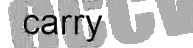

In [602]:
print(record_adv_text[10])
show(adv_img[10])

In [49]:
# wm0's grayscale is 174
restore_word_wm = []
for font_name in tqdm(fonts[:5]):
    restore_wmi = []
    for case in word_cases:
        with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
            _, input_img, _, gt_txt, target_txt = pickle.load(f)
        input_img = np.asarray(input_img)
        title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
        with open(f'wm_result/{title}.pkl', 'rb') as f:
            (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, adv_img, record_adv_text, record_iter, (duration, total_iter), rgb_img) = pickle.load(f)
        input_img, adv_img, gt_txt, target_txt, record_adv_text, record_iter, wm0_img, record_text, rgb_img = \
        filter_word_wm(input_img, adv_img, gt_txt, target_txt, record_adv_text, record_iter, wm0_img, record_text, rgb_img)

        input_img = (255 * cvt2raw(wm0_img)).astype('uint8')
        adv_img = (255 * cvt2raw(adv_img)).astype('uint8')
        cnt = 0
        for pred_txt, raw_txt in zip(record_text, gt_txt):
            if pred_txt == raw_txt:
                cnt += 1
        accuracy = cnt / len(gt_txt)

        mse, psnr, ssim = pert_eval(adv_img, input_img)
        wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)
        t_asr, u_asr, fail_r = asr_eval(record_adv_text, target_txt, gt_txt)
        avg_success_iter, avg_iter_time = iter_eval(record_iter, duration)
        restore_wmi.append((mse, psnr, ssim, wm_mse, t_asr, u_asr, avg_success_iter, avg_iter_time, accuracy))
    restore_word_wm.append(restore_wmi)







  0%|          | 0/5 [00:00<?, ?it/s]





 20%|██        | 1/5 [00:05<00:23,  5.88s/it]





 40%|████      | 2/5 [00:10<00:16,  5.64s/it]





 60%|██████    | 3/5 [00:15<00:10,  5.34s/it]





 80%|████████  | 4/5 [00:20<00:05,  5.29s/it]





100%|██████████| 5/5 [00:25<00:00,  5.11s/it]

### sentence level

In [50]:
sentence_cases = ['word']
nb_iter = 2000
# sentence image data
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/intersect_image_data/'

In [51]:
# wm0's grayscale is 174
restore_sentence_wm = []
for font_name in tqdm(fonts[:5]):
    restore_wmi = []
    for case in sentence_cases:
        with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
            _, input_img, _, gt_txt, target_txt = pickle.load(f)
        input_img = np.asarray(input_img)
        title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
        with open(f'wm_result/{title}.pkl', 'rb') as f:
            (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, adv_img, record_adv_text, record_iter, (duration, total_iter), rgb_img) = pickle.load(f)
        
        input_img = (255 * cvt2raw(wm0_img)).astype('uint8')
        adv_img = (255 * cvt2raw(adv_img)).astype('uint8')
        cnt = 0
        for pred_txt, raw_txt in zip(record_text, gt_txt):
            if pred_txt == raw_txt:
                cnt += 1
        accuracy = cnt / len(gt_txt)

        mse, psnr, ssim = pert_eval(adv_img, input_img)
        wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)
        t_asr, u_asr, fail_r = asr_eval(record_adv_text, target_txt, gt_txt)
        avg_success_iter, avg_iter_time = iter_eval(record_iter, duration)
        restore_wmi.append((mse, psnr, ssim, wm_mse, t_asr, u_asr, avg_success_iter, avg_iter_time, accuracy))
    restore_sentence_wm.append(restore_wmi)







  0%|          | 0/5 [00:00<?, ?it/s]





 20%|██        | 1/5 [07:37<30:31, 457.98s/it]





 40%|████      | 2/5 [10:57<19:00, 380.31s/it]





 60%|██████    | 3/5 [14:23<10:56, 328.29s/it]





 80%|████████  | 4/5 [17:41<04:49, 289.21s/it]





100%|██████████| 5/5 [21:14<00:00, 266.06s/it]

### paragraph level

In [52]:
sentence_cases = ['paragraph']
nb_iter = 1000
# sentence image data
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/paragraph_image_data/'

In [53]:
# wm0's grayscale is 174
restore_paragraph_wm = []
for font_name in tqdm(fonts[:5]):
    restore_wmi = []
    for case in sentence_cases:
        with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
            _, input_img, _, gt_txt, target_txt = pickle.load(f)
        input_img = np.asarray(input_img)
        title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
        with open(f'wm_result/{title}.pkl', 'rb') as f:
            (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, adv_img, record_adv_text, record_iter, (duration, total_iter), rgb_img) = pickle.load(f)
        
        input_img = (255 * cvt2raw(wm0_img)).astype('uint8')
        adv_img = (255 * cvt2raw(adv_img)).astype('uint8')
        cnt = 0
        for pred_txt, raw_txt in zip(record_text, gt_txt):
            if pred_txt == raw_txt:
                cnt += 1
        accuracy = cnt / len(gt_txt)

        mse, psnr, ssim = pert_eval(adv_img, input_img)
        wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)
        t_asr, u_asr, fail_r = asr_eval(record_adv_text, target_txt, gt_txt)
        avg_success_iter, avg_iter_time = iter_eval(record_iter, duration)
        restore_wmi.append((mse, psnr, ssim, wm_mse, t_asr, u_asr, avg_success_iter, avg_iter_time, accuracy))
    restore_paragraph_wm.append(restore_wmi)







  0%|          | 0/5 [00:00<?, ?it/s]





 20%|██        | 1/5 [00:45<03:03, 45.86s/it]





 40%|████      | 2/5 [01:14<02:02, 40.76s/it]





 60%|██████    | 3/5 [01:43<01:14, 37.10s/it]





 80%|████████  | 4/5 [02:06<00:32, 32.80s/it]





100%|██████████| 5/5 [02:26<00:00, 29.06s/it]

### latex

In [54]:
new_restore_full_wm = []
for i, (_restore, _restore_op, _restore_pa) in enumerate(zip(restore_word_wm, restore_sentence_wm, restore_paragraph_wm)):
    new_restore_full_wm.append(_restore+_restore_op+_restore_pa)

In [56]:
latex_line = ''
index_name = [
    'MSE', 'PSNR', 'SSIM', 'WM', 'ASR*', 'ASR', '$\mathrm{I_{avg}}$', '$\mathrm{T_{iter}}$', 'accuracy'
]
for i, font_name in enumerate(fonts[:5]):
    latex_line += f' & {font_name[0].upper() + font_name[1:]} '
    for j in range(len(new_restore_full_wm[0])): # cases  
        for k in [0, 1, 2, 6]:
            if k == 6:
                latex_line += '& ' + f'{int(new_restore_full_wm[i][j][k])}' + ' '
            elif k == 4:
                latex_line += '& ' + f'{(new_restore_full_wm[i][j][k]):.3f}' + ' '
            else:
                latex_line += '& ' + f'{new_restore_full_wm[i][j][k]:.3f}' + ' '
    latex_line += '\\\\ \n'   
print(latex_line)

 & Courier & 12.897 & 37.026 & 0.993 & 51 & 3.427 & 42.782 & 0.999 & 60 & 8.676 & 38.747 & 0.998 & 57 \\ 
 & Georgia & 35.418 & 32.639 & 0.985 & 131 & 5.204 & 40.968 & 0.999 & 90 & 9.233 & 38.477 & 0.998 & 81 \\ 
 & Helvetica & 40.026 & 32.107 & 0.984 & 124 & 5.421 & 40.790 & 0.999 & 91 & 11.822 & 37.404 & 0.998 & 96 \\ 
 & Times & 34.764 & 32.719 & 0.985 & 160 & 4.500 & 41.598 & 0.999 & 79 & 6.709 & 39.864 & 0.999 & 74 \\ 
 & Arial & 44.619 & 31.636 & 0.982 & 138 & 6.126 & 40.259 & 0.999 & 98 & 12.009 & 37.336 & 0.998 & 98 \\ 



## protection mechanism

In [2711]:
cases = ['protect']
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/word_image_data/'
# img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/intersect_image_data'

In [2712]:
# wm0's grayscale is 174
restore_protect_wm = []
for font_name in tqdm(fonts[:5]):
    restore_wmi = []
    for case in cases:
        with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
            _, input_img, _, gt_txt, target_txt = pickle.load(f)
        input_img = np.asarray(input_img)
        title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter2000"
        with open(f'wm_result/{title}.pkl', 'rb') as f:
            (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, adv_img, record_adv_text, record_iter, (duration, total_iter), rgb_img) = pickle.load(f)

        input_img = (255 * cvt2raw(wm0_img)).astype('uint8')
        adv_img = (255 * cvt2raw(adv_img)).astype('uint8')
        cnt = 0
        for pred_txt, raw_txt in zip(record_text, gt_txt):
            if pred_txt == raw_txt:
                cnt += 1
        accuracy = cnt / len(gt_txt)

        mse, psnr, ssim = pert_eval(adv_img, input_img)
        wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)
        t_asr, u_asr, fail_r = asr_eval(record_adv_text, target_txt, gt_txt)
        avg_success_iter, avg_iter_time = iter_eval(record_iter, duration)
        restore_wmi.append((mse, psnr, ssim, wm_mse, t_asr, u_asr, avg_success_iter, avg_iter_time, accuracy))
    restore_protect_wm.append(restore_wmi)




  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:04<00:19,  4.93s/it]


 40%|████      | 2/5 [00:10<00:15,  5.22s/it]


 60%|██████    | 3/5 [00:16<00:10,  5.39s/it]


 80%|████████  | 4/5 [00:23<00:05,  5.89s/it]


100%|██████████| 5/5 [00:30<00:00,  6.16s/it]

In [2724]:
for font_name in fonts[:5]:
    with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
        _, input_img, _, gt_txt, target_txt = pickle.load(f)
    title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter2000"
    with open(f'wm_result/{title}.pkl', 'rb') as f:
        (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, adv_img, record_adv_text, record_iter, (duration, total_iter), rgb_img) = pickle.load(f)
    idx = target_txt.index('part')
    show(adv_img[idx]).save(f'sample_images_calamari/protection-{font_name}-part.jpg', quality=100)

In [2738]:
title = 'Courier-protect-l2-eps0.2-ieps5.0-iter2000'

In [2751]:
for font_name in fonts[:5]:
    title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter2000"
    with open(f'wm_result/{title}.pkl', 'rb') as f:
        (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, adv_img, record_adv_text, record_iter, (duration, total_iter), rgb_img) = pickle.load(f)
    cnt, cnt_0 = 0, 0
    for i, t in enumerate(zip(record_text, record_adv_text)):
        if t[0]!=t[1]:
            if len(t[0]) < len(t[1]):
                cnt += 1
            cnt_0 += 1
#             print(i, t)
    print(font_name, cnt / cnt_0)

Courier 0.6458132820019249
Georgia 0.11549295774647887
Helvetica 0.0829817158931083
times 0.09259259259259259
Arial 0.13921113689095127


### latex

In [2715]:
latex_line = ''
index_name = [
    'MSE', 'PSNR', 'SSIM', 'WM', 'ASR*', 'ASR', '$\mathrm{I_{avg}}$', '$\mathrm{T_{iter}}$', 'accuracy'
]
for i, font_name in enumerate(fonts[:5]):
    latex_line += f'{font_name[0].upper() + font_name[1:]} '
    for j in range(len(cases)): # cases  
        for k in [0, 6, 4, -1]:
            if k == 6:
                latex_line += '& ' + f'{int(restore_protect_wm[i][j][k])}' + ' '
            elif k == 4:
                latex_line += '& ' + f'{(restore_protect_wm[i][j][k]):.1f}' + ' '
            elif k == -1:
                latex_line += '& ' + f'{restore_protect_wm[i][j][k]:.3f}' + ' '
            else:
                latex_line += '& ' + f'{restore_protect_wm[i][j][k]:.1f}' + ' '
    latex_line += '& \\\\ \\hline \n'   
print(latex_line)

Courier & 0.6 & 5 & 1.0 & 0.066 & \\ \hline 
Georgia & 0.2 & 1 & 1.0 & 0.768 & \\ \hline 
Helvetica & 0.2 & 1 & 1.0 & 0.531 & \\ \hline 
Times & 0.2 & 1 & 1.0 & 0.753 & \\ \hline 
Arial & 0.2 & 1 & 1.0 & 0.715 & \\ \hline 



# non-overlap wm attack

In [440]:
cases = ['easy']
# word image data
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/word_image_data'
nb_iter = 2000

In [441]:
title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"

In [467]:
# wm0's grayscale is 174
restore_long_wm = []
for font_name in fonts[:5]:
    with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
        _, input_img, _, gt_txt, target_txt = pickle.load(f)
    input_img = np.asarray(input_img)
    title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
    with open(f'long_attack_result/{title}.pkl', 'rb') as f:
        (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, adv_img, record_adv_text, record_iter, (duration, total_iter), rgb_img) = pickle.load(f)
    input_img, adv_img, gt_txt, target_txt, record_adv_text, record_iter, wm0_img, record_text, rgb_img = \
    filter_word_wm(input_img, adv_img, gt_txt, target_txt, record_adv_text, record_iter, wm0_img, record_text, rgb_img)
    print(f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter} {len(adv_img)} examples")
    print(f"wm0 accuracy-{accuracy:.3f}")
    
    input_img = (255 * cvt2raw(wm0_img)).astype('uint8')
    adv_img = (255 * cvt2raw(adv_img)).astype('uint8')
    
    mse, psnr, ssim = pert_eval(adv_img, input_img)
    wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)
    t_asr, u_asr, fail_r = asr_eval(record_adv_text, target_txt, gt_txt)
    avg_success_iter, avg_iter_time = iter_eval(record_iter, duration)
    record_iter = np.array(record_iter)
    avg_success_iter = np.mean(record_iter[record_iter != 0])
    print(avg_success_iter)
    restore_long_wm.append((mse, psnr, ssim, wm_mse, t_asr, u_asr, avg_success_iter, avg_iter_time, accuracy))

Courier-easy-l2-eps0.2-ieps5.0-iter2000 3481 examples
wm0 accuracy-0.395
186.31399791594305
Georgia-easy-l2-eps0.2-ieps5.0-iter2000 3481 examples
wm0 accuracy-0.813
546.1063658340048
Helvetica-easy-l2-eps0.2-ieps5.0-iter2000 3481 examples
wm0 accuracy-0.915
474.3914974619289
times-easy-l2-eps0.2-ieps5.0-iter2000 3481 examples
wm0 accuracy-0.899
515.2866666666666
Arial-easy-l2-eps0.2-ieps5.0-iter2000 3481 examples
wm0 accuracy-0.928
463.85967213114753


gt:trois
target:trows


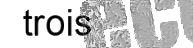

In [478]:
idx = 66
print(f'gt:{gt_txt[idx]}')
print(f'target:{target_txt[idx]}')
Image.fromarray(adv_img[idx])

## latex

In [469]:
latex_line = ''
index_name = [
    'MSE', 'PSNR', 'SSIM', 'WM', 'ASR*', 'ASR', '$\mathrm{I_{avg}}$', '$\mathrm{T_{iter}}$', 'accuracy'
]
for i, font_name in enumerate(fonts[:5]):
    latex_line += f'{font_name[0].upper() + font_name[1:]} '
    for k in [0, 1, 2, 4, 5, 6, 7]:
        if k == 7:
            latex_line += '& ' + f'{(restore_long_wm[i][k]):.1f}' + ' '
        elif k == 6:
            latex_line += '& ' + f'{int(restore_long_wm[i][k])}' + ' '
        elif k == 4 or k == 5:
            latex_line += '& ' + f'{(restore_long_wm[i][k]):.2f}' + ' '
        else:
            latex_line += '& ' + f'{restore_long_wm[i][k]:.1f}' + ' '
    latex_line += '\\\\ \n'   
print(latex_line)

Courier & 48.5 & 31.3 & 1.0 & 0.83 & 0.88 & 186 & 4.0 \\ 
Georgia & 156.6 & 26.2 & 1.0 & 0.36 & 0.44 & 546 & 4.9 \\ 
Helvetica & 146.8 & 26.5 & 1.0 & 0.45 & 0.52 & 474 & 4.5 \\ 
Times & 145.9 & 26.5 & 1.0 & 0.43 & 0.51 & 515 & 4.8 \\ 
Arial & 153.5 & 26.3 & 1.0 & 0.44 & 0.51 & 463 & 4.5 \\ 



# basic optimization

In [565]:
cases = ['easy', 'random', 'hard', 'insert', 'delete', 'replace-full-word']
restore_opt = []
for case in cases:
    restore_i = []
    for font_name in fonts[:5]:
        with open(f'basic_opt_result/{font_name}-{case}.pkl', 'rb') as f:
            (adv_img, adv_txt_list, adv_l2, adv_iter_list, adv_asr_list, duration) = pickle.load(f)
        print(f"{font_name}-{case} {len(adv_img)} examples")

        with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
            _, input_img, len_x, gt_txt, target_txt = pickle.load(f)
        input_img = np.asarray(input_img)

        new_input_img, new_len_x, new_gt_txt, new_target_txt = [], [], [], []
        for i, gt in enumerate(gt_txt):
            if gt in intersect_word:
                new_input_img.append(input_img[i])
                new_len_x.append(len_x[i])
                new_gt_txt.append(gt_txt[i])
                new_target_txt.append(target_txt[i])
        input_img, len_x, gt_txt, target_txt = np.asarray(new_input_img), new_len_x, new_gt_txt, new_target_txt
        nb_sample = len(adv_img)
        input_img, len_x, gt_txt, target_txt = input_img[:nb_sample], len_x[:nb_sample], gt_txt[:nb_sample], target_txt[:nb_sample]

        input_img = (255 * cvt2raw(input_img)).astype('uint8')
        adv_img = (255 * cvt2raw(adv_img)).astype('uint8')

        mse, psnr, ssim = pert_eval(adv_img, input_img)
        wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)

        MAX_ITERATIONS = 1000
        batch_iter = len(adv_img) // batch_size
        total_asr_list = [0] * MAX_ITERATIONS
        adv_asr_list = np.asarray(adv_asr_list)
        for b in range(batch_iter):
            batch_asr_list = adv_asr_list[b]
            for idx in range(len(batch_asr_list)):
                if batch_asr_list[idx] == -1:
                    break
            batch_asr_list[idx:] = batch_asr_list[idx - 1]
            adv_asr_list[b] = list(batch_asr_list)

        for i in range(MAX_ITERATIONS):
            for b in range(batch_iter):
                total_asr_list[i] += adv_asr_list[b][i]
        t_asr = max(total_asr_list) / len(adv_img)

        adv_iter_list = np.array(adv_iter_list)
        avg_success_iter = int(np.mean(adv_iter_list[adv_iter_list != -1]))
        adv_iter_time = duration / total_asr_list.index(max(total_asr_list))
        restore_i.append((mse, psnr, ssim, wm_mse, t_asr, None, avg_success_iter, avg_iter_time, total_asr_list))
    restore_opt.append(restore_i)

Courier-easy 3400 examples
Georgia-easy 3400 examples
Helvetica-easy 3400 examples
times-easy 3400 examples
Arial-easy 3400 examples
Courier-random 3400 examples
Georgia-random 3400 examples
Helvetica-random 3400 examples
times-random 3400 examples
Arial-random 3400 examples
Courier-hard 3400 examples
Georgia-hard 3400 examples
Helvetica-hard 3400 examples
times-hard 3400 examples
Arial-hard 3400 examples
Courier-insert 1000 examples
Georgia-insert 1000 examples
Helvetica-insert 1000 examples
times-insert 1000 examples
Arial-insert 1000 examples
Courier-delete 1000 examples
Georgia-delete 1000 examples
Helvetica-delete 1000 examples
times-delete 1000 examples
Arial-delete 1000 examples
Courier-replace-full-word 1000 examples
Georgia-replace-full-word 1000 examples
Helvetica-replace-full-word 1000 examples
times-replace-full-word 1000 examples
Arial-replace-full-word 1000 examples


## latex

In [564]:
latex_line = ''
index_name = [
    'MSE', 'PSNR', 'SSIM', 'WM', 'ASR', 'ASR*', '$\mathrm{I_{avg}}$', '$\mathrm{T_{iter}}$'
]
for i, font_name in enumerate(fonts[:5]):
    latex_line += f'{font_name[0].upper() + font_name[1:]} '
    for j in range(5): # cases  
        for k in [0, 4, 6]:
            if k == 6:
                latex_line += '& ' + f'{int(restore_opt[j][i][k])}' + ' '
            else:
                latex_line += '& ' + f'{restore_opt[j][i][k]:.1f}' + ' '
    latex_line += '\\\\ \n'   
print(latex_line)

Courier & 25.4 & 1.0 & 266 & 30.3 & 1.0 & 313 & 36.7 & 1.0 & 321 & 25.4 & 1.0 & 309 & 13.6 & 1.0 & 43 \\ 
Georgia & 52.0 & 1.0 & 292 & 59.4 & 1.0 & 318 & 67.5 & 1.0 & 328 & 41.6 & 1.0 & 337 & 45.0 & 1.0 & 169 \\ 
Helvetica & 52.1 & 1.0 & 301 & 60.2 & 1.0 & 328 & 68.2 & 1.0 & 340 & 47.1 & 1.0 & 321 & 45.0 & 1.0 & 178 \\ 
Times & 49.9 & 1.0 & 294 & 56.1 & 1.0 & 324 & 61.6 & 1.0 & 345 & 41.7 & 1.0 & 314 & 44.3 & 1.0 & 172 \\ 
Arial & 56.3 & 1.0 & 304 & 65.3 & 1.0 & 327 & 73.8 & 1.0 & 341 & 48.3 & 1.0 & 324 & 51.0 & 1.0 & 176 \\ 



mormal 2.0962534 196.84


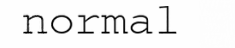

In [493]:
mean_pert = np.mean(np.sqrt(adv_l2[adv_l2 < 1e9]))
mean_iter = np.mean(np.array(adv_iter_list))
print(adv_txt_list[idx], mean_pert, mean_iter)
show(adv_img[idx])

# WM Opt

In [589]:
cases = ['easy', 'random', 'hard', 'insert', 'delete', 'replace-full-word']
restore_opt_wm = []
for case in cases:
    restore_i = []
    for font_name in fonts[:5]:
        with open(f'wm_opt_result/{font_name}-{case}.pkl', 'rb') as f:
            (adv_img, adv_txt_list, adv_l2, adv_iter_list, adv_asr_list, duration) = pickle.load(f)
        print(f"{font_name}-{case} {len(adv_img)} examples")

        with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
            _, _, len_x, gt_txt, target_txt = pickle.load(f)
        
        if case in ['easy', 'random', 'hard']:
            title = f"{font_name}-{case}-l2-eps0.2-ieps5.0-iter1000"
        else:
            title = f"{font_name}-{case}-l2-eps0.2-ieps5.0-iter2000"
        with open(f'wm_result/{title}.pkl', 'rb') as f:
            (_, _, _, wm0_img, _, _, _, _, _, _, _) = pickle.load(f)

        new_input_img, new_len_x, new_gt_txt, new_target_txt = [], [], [], []
        for i, gt in enumerate(gt_txt):
            if gt in intersect_word:
                new_input_img.append(wm0_img[i])
                new_len_x.append(len_x[i])
                new_gt_txt.append(gt_txt[i])
                new_target_txt.append(target_txt[i])
        input_img, len_x, gt_txt, target_txt = np.asarray(new_input_img), new_len_x, new_gt_txt, new_target_txt
        nb_sample = len(adv_img)
        input_img, len_x, gt_txt, target_txt = input_img[:nb_sample], len_x[:nb_sample], gt_txt[:nb_sample], target_txt[:nb_sample]
        
        input_img = (255 * cvt2raw(input_img)).astype('uint8')
        adv_img = (255 * cvt2raw(adv_img)).astype('uint8')

        mse, psnr, ssim = pert_eval(adv_img, input_img)
        wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)

        MAX_ITERATIONS = 1000
        batch_iter = len(adv_img) // batch_size
        total_asr_list = [0] * MAX_ITERATIONS
        adv_asr_list = np.asarray(adv_asr_list)
        for b in range(batch_iter):
            batch_asr_list = adv_asr_list[b]
            for idx in range(len(batch_asr_list)):
                if batch_asr_list[idx] == -1:
                    break
            batch_asr_list[idx:] = batch_asr_list[idx - 1]
            adv_asr_list[b] = list(batch_asr_list)

        for i in range(MAX_ITERATIONS):
            for b in range(batch_iter):
                total_asr_list[i] += adv_asr_list[b][i]
        t_asr = max(total_asr_list) / len(adv_img)

        adv_iter_list = np.array(adv_iter_list)
        avg_success_iter = int(np.mean(adv_iter_list[adv_iter_list != -1]))
        adv_iter_time = duration / total_asr_list.index(max(total_asr_list))
        restore_i.append((mse, psnr, ssim, wm_mse, t_asr, None, avg_success_iter, avg_iter_time, total_asr_list))
    restore_opt_wm.append(restore_i)

Courier-easy 3400 examples
Courier-easy 3400 examples.
Georgia-easy 3400 examples
Georgia-easy 3400 examples.
Helvetica-easy 3400 examples
Helvetica-easy 3400 examples.
times-easy 3400 examples
times-easy 3400 examples.
Arial-easy 3400 examples
Arial-easy 3400 examples.
Courier-random 3400 examples
Courier-random 3400 examples.
Georgia-random 3400 examples
Georgia-random 3400 examples.
Helvetica-random 3400 examples
Helvetica-random 3400 examples.
times-random 3400 examples
times-random 3400 examples.
Arial-random 3400 examples
Arial-random 3400 examples.
Courier-hard 3400 examples
Courier-hard 3400 examples.
Georgia-hard 3400 examples
Georgia-hard 3400 examples.
Helvetica-hard 3400 examples
Helvetica-hard 3400 examples.
times-hard 3400 examples
times-hard 3400 examples.
Arial-hard 3400 examples
Arial-hard 3400 examples.
Courier-insert 1000 examples
Courier-insert 1000 examples.
Georgia-insert 1000 examples
Georgia-insert 1000 examples.
Helvetica-insert 1000 examples
Helvetica-insert 1

## latex

In [675]:
latex_line = ''
index_name = [
    'MSE', 'PSNR', 'SSIM', 'WM', 'ASR', 'ASR*', '$\mathrm{I_{avg}}$', '$\mathrm{T_{iter}}$'
]
for i, font_name in enumerate(fonts[:5]):
    latex_line += f'{font_name[0].upper() + font_name[1:]} '
    for j in range(5): # cases  
        for k in [0, 4, 6]:
            if k == 6:
                latex_line += '& ' + f'{int(restore_opt_wm[j][i][k])}' + ' '
            else:
                latex_line += '& ' + f'{restore_opt_wm[j][i][k]:.1f}' + ' '
    latex_line += '\\\\ \n'   
print(latex_line)

Courier & 16.7 & 1.0 & 116 & 20.1 & 1.0 & 96 & 20.4 & 1.0 & 95 & 31.1 & 1.0 & 303 & 3.2 & 1.0 & 13 \\ 
Georgia & 31.6 & 1.0 & 30 & 35.1 & 1.0 & 32 & 38.3 & 1.0 & 37 & 21.7 & 1.0 & 12 & 16.2 & 1.0 & 9 \\ 
Helvetica & 33.3 & 1.0 & 31 & 37.0 & 1.0 & 42 & 38.8 & 1.0 & 53 & 25.1 & 1.0 & 13 & 16.5 & 1.0 & 9 \\ 
Times & 30.3 & 1.0 & 22 & 33.9 & 1.0 & 26 & 35.9 & 1.0 & 36 & 19.2 & 1.0 & 11 & 15.4 & 1.0 & 8 \\ 
Arial & 37.2 & 1.0 & 30 & 40.4 & 1.0 & 45 & 43.6 & 1.0 & 50 & 25.4 & 1.0 & 16 & 19.4 & 1.0 & 10 \\ 



## latex replace-full-word

In [3032]:
latex_line = ''
index_name = [
    'MSE', 'PSNR', 'SSIM', 'WM', 'ASR', 'ASR*', '$\mathrm{I_{avg}}$', '$\mathrm{T_{iter}}$'
]
for i, font_name in enumerate(fonts[:5]):
    latex_line += f'{font_name[0].upper() + font_name[1:]} '
    for j in [5]: # cases  
        for k in [0, 1, 2, 4, 6]:
            if k == 6:
                latex_line += '& ' + f'{int(restore_opt_wm[j][i][k])}' + ' '
            elif k == 4:
                latex_line += '& ' + f'{100*restore_opt_wm[j][i][k]:.1f}' + ' '
            else:
                latex_line += '& ' + f'{restore_opt_wm[j][i][k]:.1f}' + ' '
    latex_line += '\\\\ \n'   
print(latex_line)

Courier & 41.0 & 32.0 & 1.0 & 99.7 & 421 \\ 
Georgia & 83.5 & 28.9 & 1.0 & 100.0 & 140 \\ 
Helvetica & 103.0 & 28.0 & 1.0 & 99.9 & 179 \\ 
Times & 80.4 & 29.1 & 1.0 & 100.0 & 146 \\ 
Arial & 107.8 & 27.8 & 0.9 & 100.0 & 103 \\ 



## smooth

In [3067]:
cases = ['replace-full-word']
# restore_opt_wm_smooth = []
record_mse = []
for case in cases:
    restore_i = []
    for font_name in fonts[:5]:
        with open(f'wm_opt_result/{font_name}-{case}.pkl', 'rb') as f:
            (adv_img, adv_txt_list, adv_l2, adv_iter_list, adv_asr_list, duration) = pickle.load(f)
        print(f"{font_name}-{case} {len(adv_img)} examples")

        with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
            _, _, len_x, gt_txt, target_txt = pickle.load(f)
        
        if case in ['easy', 'random', 'hard']:
            title = f"{font_name}-{case}-l2-eps0.2-ieps5.0-iter1000"
        else:
            title = f"{font_name}-{case}-l2-eps0.2-ieps5.0-iter2000"
        with open(f'wm_result/{title}.pkl', 'rb') as f:
            (_, _, _, wm0_img, _, _, _, _, _, _, _) = pickle.load(f)

        new_input_img, new_len_x, new_gt_txt, new_target_txt = [], [], [], []
        for i, gt in enumerate(gt_txt):
            if gt in intersect_word:
                new_input_img.append(wm0_img[i])
                new_len_x.append(len_x[i])
                new_gt_txt.append(gt_txt[i])
                new_target_txt.append(target_txt[i])
        input_img, len_x, gt_txt, target_txt = np.asarray(new_input_img), new_len_x, new_gt_txt, new_target_txt
        nb_sample = len(adv_img)
        input_img, len_x, gt_txt, target_txt = input_img[:nb_sample], len_x[:nb_sample], gt_txt[:nb_sample], target_txt[:nb_sample]
        
        input_img = (255 * cvt2raw(input_img)).astype('uint8')
        adv_img = (255 * cvt2raw(adv_img)).astype('uint8')
        record_mse.append(np.mean((input_img - adv_img) ** 2, axis=(1, 2)))
#         print(np.argmax(np.mean((input_img - adv_img) ** 2, axis=(1, 2))))
#         mse, psnr, ssim = pert_eval(adv_img, input_img)
#         wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)

#         MAX_ITERATIONS = 1000
#         batch_iter = len(adv_img) // batch_size
#         total_asr_list = [0] * MAX_ITERATIONS
#         adv_asr_list = np.asarray(adv_asr_list)
#         for b in range(batch_iter):
#             batch_asr_list = adv_asr_list[b]
#             for idx in range(len(batch_asr_list)):
#                 if batch_asr_list[idx] == -1:
#                     break
#             batch_asr_list[idx:] = batch_asr_list[idx - 1]
#             adv_asr_list[b] = list(batch_asr_list)

#         for i in range(MAX_ITERATIONS):
#             for b in range(batch_iter):
#                 total_asr_list[i] += adv_asr_list[b][i]
#         t_asr = max(total_asr_list) / len(adv_img)

#         adv_iter_list = np.array(adv_iter_list)
#         avg_success_iter = int(np.mean(adv_iter_list[adv_iter_list != -1]))
#         adv_iter_time = duration / total_asr_list.index(max(total_asr_list))
#         restore_i.append((mse, psnr, ssim, wm_mse, t_asr, None, avg_success_iter, avg_iter_time, total_asr_list))
#     restore_opt_wm_smooth.append(restore_i)

Courier-replace-full-word 1000 examples
Georgia-replace-full-word 1000 examples
Helvetica-replace-full-word 1000 examples
times-replace-full-word 1000 examples
Arial-replace-full-word 1000 examples


In [3084]:
# for i in range(5):
a, b = np.array(record_mse[2]), np.array(record_mse_smooth[2])
print(np.argsort(np.abs(a - b)))

[339 192 107 169 147 385 162 113 405 420 471 486 191 170 452 424 106 111
 365 129 442 372 611 333 374 954 122 984 388 499 454 126 940 439 355 119
 190 913 916 168 199 495 776 322 347 156 160 682 999 445 362 434 115 163
 131 342 390 386 167 103 964 134 117 693 161 458 427 444 317 349 139 178
 400 382 432 325 475 369 450 148 320 175  67 956 924 316   4 188 171 421
 128 416 437 685 174 663 380 152 491 141 607 952 402 704 173 664 934 615
 123 137 149 172 104 116 114 456 959 480 426 176  56 484 446 180 735 410
 121 335 624 618 623 120 165 155 641 143 138 305 153 341 159 497 337 181
 186 353 698 414 628 714 195 394 787 158 621 794 125 702 474 487 697 112
 331 197 412 366 423 790 422 361 625 187 100 676 786 725 756 633 710 493
 604  73 690 413 401 699 144 447 784 757 748 706 674 470 973  84 132 448
 415 753 783 679 418 651 680 627 183 662 127 752 441 775 453 133 196 616
 193 473 788 404 961 770 661 691 728 779 666  96 411 164 762 778 678 745
 681 760 717 695 642  64 440 451 731 399 795 419  8

In [3035]:
latex_line = ''
index_name = [
    'MSE', 'PSNR', 'SSIM', 'WM', 'ASR', 'ASR*', '$\mathrm{I_{avg}}$', '$\mathrm{T_{iter}}$'
]
for i, font_name in enumerate(fonts[:5]):
    latex_line += f'{font_name[0].upper() + font_name[1:]} '
    for j in [0]: # cases  
        for k in [0, 1, 2, 4, 6]:
            if k == 6:
                latex_line += '& ' + f'{int(restore_opt_wm_smooth[j][i][k])}' + ' '
            elif k == 4:
                latex_line += '& ' + f'{100*restore_opt_wm_smooth[j][i][k]:.1f}' + ' '
            else:
                latex_line += '& ' + f'{restore_opt_wm_smooth[j][i][k]:.1f}' + ' '
    latex_line += '\\\\ \n'   
print(latex_line)

Courier & 38.1 & 32.3 & 1.0 & 99.7 & 429 \\ 
Georgia & 76.3 & 29.3 & 1.0 & 100.0 & 155 \\ 
Helvetica & 86.5 & 28.8 & 1.0 & 100.0 & 119 \\ 
Times & 71.3 & 29.6 & 1.0 & 100.0 & 175 \\ 
Arial & 99.9 & 28.1 & 1.0 & 100.0 & 113 \\ 



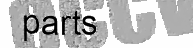

In [3039]:
cvt2Image(adv_img[target_txt.index('taupe')])

In [3087]:
case = 'replace-full-word'
# idx_list = [48, 29, 31, 37, 50]
idx_list = [397, 282, 92, 271, 178]
for i, font_name in enumerate(fonts[2:3]):
    with open(f'wm_opt_result/{font_name}-{case}-smooth.pkl', 'rb') as f:
        (adv_img, adv_txt_list, adv_l2, adv_iter_list, adv_asr_list, duration) = pickle.load(f)
#     idx = idx_list[i]
    idx = 832
    show(adv_img[idx]).save(f'result_pic/smooth1-{font_name}-{case}-{adv_txt_list[idx]}.jpg', quality=100)

In [3085]:
case = 'replace-full-word'
temp_adv_txt = []
# idx_list = [48, 29, 31, 37, 50]
idx_list = [397, 282, 92, 271, 178]
for i, font_name in enumerate(fonts[2:3]):
    with open(f'wm_opt_result/{font_name}-{case}.pkl', 'rb') as f:
        (adv_img, adv_txt_list, adv_l2, adv_iter_list, adv_asr_list, duration) = pickle.load(f)
#     idx = idx_list[2]
    idx = 832
    show(adv_img[idx]).save(f'result_pic/unsmooth1-{font_name}-{case}-{adv_txt_list[idx]}.jpg', quality=100)
    temp_adv_txt.append(adv_txt_list)

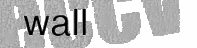

In [3086]:
show(adv_img[832])

# Transferability

## tesseract 4.1

In [ ]:
import pytesseract as tess

In [101]:
pert_type = '2'
eps_iter = 5.0

### wm0

In [ ]:
# wm0's grayscale is 174
for font_name in fonts[:1]:
    title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
    with open(f'wm_result/{title}.pkl', 'rb') as f:
        (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, adv_img, record_adv_text, record_iter, (duration, i), rgb_img) = pickle.load(f)    
    tess_text = []
    for wm0 in tqdm(wm0_img):
        tess_text.append(tess.image_to_string(show(wm0)))
    with open(f'wm_result/transferability/wm0/{title}.pkl', 'wb') as f:
        pickle.dump(tess_text, f)

In [426]:
wm0_accuracy = []
case = 'easy'
nb_iter = 1000
for font_name in fonts[:5]:
    title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
    with open(f'wm_result/transferability/wm0/{title}.pkl', 'rb') as f:
        tess_text = pickle.load(f)
    with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
        _, _, _, gt_txt, _ = pickle.load(f)
    
    cnt = 0
    for tess_t, gt_t in zip(tess_text, gt_txt):
        if tess_t == gt_t:
            cnt += 1
    print(f'{font_name}', cnt/len(tess_text))
    wm0_accuracy.append(cnt/len(tess_text))

Courier 0.003963759909399773
Georgia 0.11483155299917831
Helvetica 0.34840974803800084
times 0.08635154491508083
Arial 0.49771973466003316


## replace-full-word
basic attack and wm attack

In [393]:
case = 'replace-full-word'
nb_iter = 2000

In [419]:
restore_trans_word = []
restore_trans_word_wm = []
for font_name in fonts[:5]:
    restore_i = []
    title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
    with open(f'wm_result/transferability/{title}.pkl', 'rb') as f:
        tess_text, tess_text_wm = pickle.load(f)
    with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
        _, _, _, gt_txt, target_txt = pickle.load(f)
    t_asr, u_asr, fail_r = asr_eval(tess_text, target_txt, gt_txt)
    restore_trans_word.append((t_asr, u_asr, fail_r))
    t_asr, u_asr, fail_r = asr_eval(tess_text_wm, target_txt, gt_txt)
    restore_trans_word_wm.append((t_asr, u_asr, fail_r))

## hard

In [410]:
case = 'hard'
nb_iter = 1000

In [421]:
restore_trans_hard = []
restore_trans_hard_wm = []
for font_name in fonts[:5]:
    restore_i = []
    title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
    with open(f'wm_result/transferability/{title}.pkl', 'rb') as f:
        tess_text, tess_text_wm = pickle.load(f)
    with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
        _, _, _, gt_txt, target_txt = pickle.load(f)
    t_asr, u_asr, fail_r = asr_eval(tess_text, target_txt, gt_txt)
    restore_trans_hard.append((t_asr, u_asr, fail_r))
    t_asr, u_asr, fail_r = asr_eval(tess_text_wm, target_txt, gt_txt)
    restore_trans_hard_wm.append((t_asr, u_asr, fail_r))

### latex

In [ ]:
latex_line = ''
index_name = [
    'MSE', 'PSNR', 'SSIM', 'WM', 'ASR*', 'ASR', '$\mathrm{I_{avg}}$', '$\mathrm{T_{iter}}$'
]
for i, font_name in enumerate(fonts[:5]):
    latex_line += f'{font_name[0].upper() + font_name[1:]} '
    for j in range(len(new_restore_full[0])): # cases  
        for k in [0, 1, 2, 4, 6, 7]:
            if k == 6:
                latex_line += '& ' + f'{int(new_restore_full[i][j][k])}' + ' '
            elif k == 4:
                latex_line += '& ' + f'{(new_restore_full[i][j][k]):.1f}' + ' '
            else:
                latex_line += '& ' + f'{new_restore_full[i][j][k]:.1f}' + ' '
    latex_line += '\\\\ \n'
print(latex_line)

In [427]:
restore_trans_hard

[(0.0, 0.9640907785119218, 0.03590922148807814),
 (0.0, 0.9956908934214306, 0.0043091065785693765),
 (0.0, 0.9956908934214306, 0.0043091065785693765),
 (0.0, 0.9956908934214306, 0.0043091065785693765),
 (0.0, 0.9959781671933352, 0.004021832806664752)]

In [431]:
latex_line = ''
new_restore = [restore_trans_hard, restore_trans_word, wm0_accuracy, 
               restore_trans_hard_wm, restore_trans_word_wm]
for i, font_name in enumerate(fonts[:5]): # font:
    latex_line += f'{font_name[0].upper() + font_name[1:]} '
    for j in range(5): # cases
        if j == 2:
            latex_line += '& ' + f'{ne8w_restore[j][i]:.2f} '
        else:
            latex_line += '& ' + f'{new_restore[j][i][1]:.2f} '
    latex_line += '\\\\ \n'
print(latex_line)

Courier & 0.96 & 0.96 & 0.00 & 1.00 & 1.00 \\ 
Georgia & 1.00 & 1.00 & 0.11 & 1.00 & 1.00 \\ 
Helvetica & 1.00 & 1.00 & 0.35 & 1.00 & 1.00 \\ 
Times & 1.00 & 1.00 & 0.09 & 1.00 & 1.00 \\ 
Arial & 1.00 & 1.00 & 0.50 & 1.00 & 1.00 \\ 



# plot ASR vs iteration line

In [289]:
import matplotlib.pyplot as plt

In [290]:
font_name = 'Arial'
eps = 0.2
nb_iter = 1000
record_iters = []

In [291]:
# 0
case = 'easy'
pert_type, eps_iter = 'inf', 1.0
title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
print(title)
with open(f'attack_result/{title}.pkl', 'rb') as f:
    _, _, record_iter, _ = pickle.load(f)
    record_iter[record_iter == 0] = 2001
record_iters.append(np.array(sorted(record_iter), dtype=np.uint8))

Arial-easy-linf-eps0.2-ieps1.0-iter1000


In [292]:
# 1 2 3 4 5 6
pert_type, eps_iter = '2', 5.0
for case in tqdm(['easy', 'random', 'hard', 'insert', 'delete', 'replace-full-word']):
    if case in ['insert', 'delete', 'replace-full-word', 'protect']:
        title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter2000"
    else:
        title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter1000"
    with open(f'attack_result/{title}.pkl', 'rb') as f:
        _, _, record_iter, _ = pickle.load(f)
        record_iter[record_iter == 0] = 2001
    record_iters.append(np.array(sorted(record_iter), dtype=np.uint8))

100%|██████████| 6/6 [00:14<00:00,  2.02s/it]


In [295]:
# 7, 8, 9, 10, 11, 12, 13
pert_type, eps_iter = '2', 5.0
for case in tqdm(['easy', 'random', 'hard', 'insert', 'delete', 'replace-full-word', 'protect']):
    if case in ['insert', 'delete', 'replace-full-word', 'protect']:
        title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter2000"
    else:
        title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter1000"
    with open(f'wm_result/{title}.pkl', 'rb') as f:
        (_, _, _, _, _, _, _, _, record_iter, _, _) = pickle.load(f)
        record_iter[record_iter == 0] = 2001
    record_iters.append(np.array(sorted(record_iter), dtype=np.uint8))

100%|██████████| 7/7 [01:19<00:00,  8.95s/it]


In [994]:
sentence_iters = []

In [995]:
# 0 1 2
case = ['replace-full-word', 'word', 'paragraph']
pert_type, eps_iter = '2', 5.0
title = f"{font_name}-{case[0]}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter2000"
print(title)
with open(f'attack_result/{title}.pkl', 'rb') as f:
    _, _, record_iter, _ = pickle.load(f)
    record_iter[record_iter == 0] = 3001
sentence_iters.append(np.array(sorted(record_iter), dtype=np.uint8))

title = f"{font_name}-{case[1]}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter2000"
print(title)
with open(f'attack_result/{title}.pkl', 'rb') as f:
    _, _, record_iter, _ = pickle.load(f)
    record_iter[record_iter == 0] = 3001
sentence_iters.append(np.array(sorted(record_iter), dtype=np.uint8))

title = f"{font_name}-{case[2]}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter1000"
print(title)
with open(f'attack_result/{title}.pkl', 'rb') as f:
    _, _, record_iter, _ = pickle.load(f)
    record_iter[record_iter == 0] = 3001
sentence_iters.append(np.array(sorted(record_iter), dtype=np.uint8))

Arial-replace-full-word-l2-eps0.2-ieps5.0-iter2000
Arial-word-l2-eps0.2-ieps5.0-iter2000
Arial-paragraph-l2-eps0.2-ieps5.0-iter1000


In [996]:
# 3, 4
pert_type, eps_iter = '2', 5.0
# case = 'word'
title = f"{font_name}-{case[0]}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter2000"
print(title)
with open(f'wm_result/{title}.pkl', 'rb') as f:
    (_, _, _, _, _, _, _, _, record_iter, _, _) = pickle.load(f)
    record_iter[record_iter == 0] = 3001
sentence_iters.append(np.array(sorted(record_iter), dtype=np.uint8))

title = f"{font_name}-{case[1]}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter2000"
print(title)
with open(f'wm_result/{title}.pkl', 'rb') as f:
    (_, _, _, _, _, _, _, _, record_iter, _, _) = pickle.load(f)
    record_iter[record_iter == 0] = 3001
sentence_iters.append(np.array(sorted(record_iter), dtype=np.uint8))

title = f"{font_name}-{case[2]}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter1000"
print(title)
with open(f'wm_result/{title}.pkl', 'rb') as f:
    (_, _, _, _, _, _, _, _, record_iter, _, _) = pickle.load(f)
    record_iter[record_iter == 0] = 3001
sentence_iters.append(np.array(sorted(record_iter), dtype=np.uint8))

Arial-replace-full-word-l2-eps0.2-ieps5.0-iter2000
Arial-word-l2-eps0.2-ieps5.0-iter2000
Arial-paragraph-l2-eps0.2-ieps5.0-iter1000


In [2438]:
# with open('record_iters.pkl', 'wb') as f:
#     pickle.dump(record_iters, f)

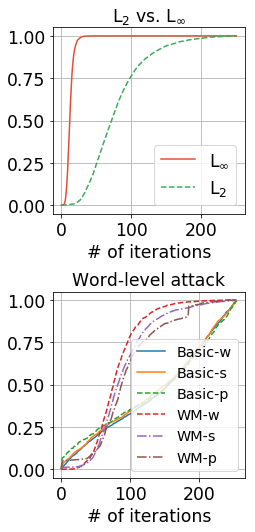

In [2436]:
iters = record_iters[:2]
iteration = max([max(i) for i in iters])
x = np.arange(iteration)
line_styles = ['-', '--']
colors = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, 2))
labels = ['$\mathrm{L_\infty}$', '$\mathrm{L_2}$']
plt.figure(figsize=[3.5, 7.5])
plt.subplot(211)
plt.grid()
for record_iter, color, linestype, label in zip(record_iters[:2], colors, line_styles, labels):
    
    y = np.zeros(iteration)
    for i in record_iter:
        y[x >= i] += 1
    y = y / len(record_iter)
    plt.plot(x, y, color=color, linestyle=linestype, label=label)
    plt.title('$\mathrm{L_2}$ vs. $\mathrm{L_{\infty}}$', fontsize='xx-large')
    plt.xlabel("# of iterations", fontsize='xx-large') 
#     plt.ylabel('ASR', fontsize='xx-large')
    plt.legend(loc=4, fontsize='xx-large')    #显示图例
plt.tick_params(labelsize=fsize)
plt.tight_layout()
# plt.savefig('result_pic/l2vslinf.pdf')

iters = sentence_iters
iteration = max([max(i) for i in iters])
x = np.arange(iteration)
line_styles = ['-', '-', '--', '--', '-.', '-.']
colors = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, 6))
labels = ['Basic-w', 'Basic-s', 'Basic-p', 'WM-w', 'WM-s', 'WM-p']
plt.subplot(212)
plt.grid()
for record_iter, color, linestyle, label in zip(sentence_iters, colors, line_styles, labels):
    y = np.zeros(iteration)
    for i in record_iter:
        y[x >= i] += 1
    y = y / len(record_iter)
    plt.plot(x, y, linestyle=linestyle, label=label)
    plt.title('Word-level attack', fontsize='xx-large')
    plt.xlabel("# of iterations", fontsize='xx-large') 
#     plt.ylabel('ASR', fontsize='xx-large')
    plt.legend(loc=4, fontsize='x-large')    #显示图例
plt.tick_params(labelsize=fsize)
plt.tight_layout()
# plt.savefig('result_pic/word_attack.pdf')
plt.savefig('result_pic/lp_word.pdf')

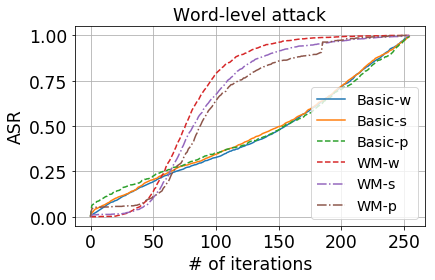

In [3088]:
iters = sentence_iters
iteration = max([max(i) for i in iters])
x = np.arange(iteration)
line_styles = ['-', '-', '--', '--', '-.', '-.']
colors = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, 6))
labels = ['Basic-w', 'Basic-s', 'Basic-p', 'WM-w', 'WM-s', 'WM-p']
plt.grid()
for record_iter, color, linestyle, label in zip(sentence_iters, colors, line_styles, labels):
    y = np.zeros(iteration)
    for i in record_iter:
        y[x >= i] += 1
    y = y / len(record_iter)
    plt.plot(x, y, linestyle=linestyle, label=label)
    plt.title('Word-level attack', fontsize='xx-large')
    plt.xlabel("# of iterations", fontsize='xx-large') 
    plt.ylabel('ASR', fontsize='xx-large')
    plt.legend(loc=4, fontsize='x-large')    #显示图例
plt.tick_params(labelsize=fsize)
plt.tight_layout()
plt.savefig('result_pic/word_attack.pdf')

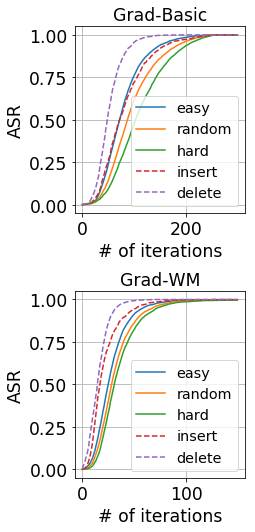

In [2756]:
fsize = 'xx-large'
colors = plt.get_cmap('RdYlGn')(np.linspace(0.0, 1, 6))
plt.figure(figsize=[3.5, 7.5])

iters = record_iters[1:6]
iteration = max([max(i) for i in iters])
iteration = 300
x = np.arange(iteration)
styles = ['-', '-', '-', '--', '--']
labels = ['easy', 'random', 'hard', 'insert', 'delete']
plt.subplot(211)
plt.grid()
for record_iter, line_style, label in zip(iters, styles, labels):
    y = np.zeros(iteration)
    for i in record_iter:
        y[x >= i] += 1
    y = y / len(record_iter)
    plt.plot(x, y, linestyle=line_style, label=label)
    plt.xlabel("# of iterations", fontsize='xx-large')
    plt.ylabel('ASR', fontsize='xx-large')
    plt.legend(fontsize='x-large')  #显示图例
plt.title('Grad-Basic', fontsize=fsize)
plt.tick_params(labelsize=fsize)
plt.tight_layout()
# plt.savefig('result_pic/basic.eps')

iters = record_iters[7:12]
iteration = max([max(i) for i in iters])
iteration = 150
x = np.arange(iteration)
styles = ['-', '-', '-', '--', '--']
labels = ['easy', 'random', 'hard', 'insert', 'delete']
plt.subplot(212)
plt.grid()
for record_iter, line_style, label in zip(iters, styles, labels):
    y = np.zeros(iteration)
    for i in record_iter:
        y[x >= i] += 1
    y = y / len(record_iter)
    plt.plot(x, y, linestyle=line_style, label=label)
    plt.xlabel("# of iterations", fontsize='xx-large')
    plt.ylabel('ASR', fontsize='xx-large')
    plt.legend(loc=4, fontsize='x-large')  #显示图例
plt.title('Grad-WM', fontsize=fsize)
plt.tick_params(labelsize=fsize)
plt.tight_layout()
plt.savefig('result_pic/grad.pdf')

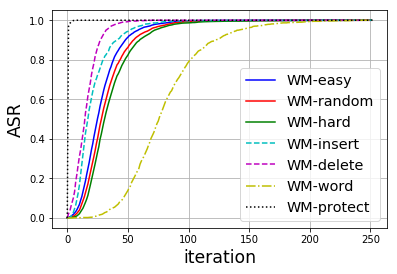

In [616]:
iters = record_iters[7:14]
iteration = max([max(i) for i in iters])
x = np.arange(iteration)
styles = ['b', 'r', 'g', 'c--', 'm--', 'y-.', 'k:']
labels = ['WM-easy', 'WM-random', 'WM-hard', 'WM-insert', 'WM-delete', 
          'WM-word', 'WM-protect']
plt.grid()
for record_iter, line_style, label in zip(iters, styles, labels):
    y = np.zeros(iteration)
    for i in record_iter:
        y[x >= i] += 1
    y = y / len(record_iter)
    plt.plot(x, y, line_style, label=label)
    plt.xlabel("# of iterations", fontsize='xx-large') 
    plt.ylabel('ASR', fontsize='xx-large')
    plt.legend(loc=4, fontsize='x-large')    #显示图例
plt.savefig('result_pic/wm.eps')

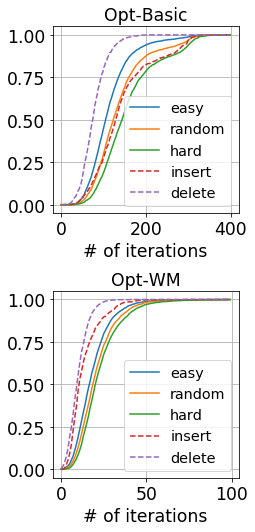

In [2754]:
font_name = 'Arial'
plt.figure(figsize=[3.5, 7.5])
line_style = ['-', '-', '-', '--', '--']
iteration = 400
x = np.arange(iteration)
plt.subplot(211)
plt.grid()
labels = ['easy', 'random', 'hard', 'insert', 'delete']
for i, case in (enumerate(['easy', 'random', 'hard', 'insert', 'delete'])):
    with open(f'basic_opt_result/{font_name}-{case}.pkl', 'rb') as f:
        (adv_img, adv_txt_list, adv_l2, adv_iter_list, adv_asr_list, duration) = pickle.load(f)
    total_iter_list = restore_opt[i][4][-1]
    y = np.array(total_iter_list) / len(adv_img)
#     plt.plot(x, y[:iteration], line_style[i], label=f'opt-{labels[i]}')
    plt.plot(x, y[:iteration], linestyle=line_style[i], label=labels[i])
    plt.xlabel("# of iterations", fontsize='xx-large') 
#     plt.ylabel('ASR', fontsize='xx-large')
    plt.legend(loc=4, fontsize='x-large')    #显示图例
plt.title('Opt-Basic', fontsize=fsize)
plt.tick_params(labelsize=fsize)
plt.tight_layout()
# plt.savefig('result_pic/basic_opt.eps')

iteration = 100
x = np.arange(iteration)
plt.subplot(212)
plt.grid()
labels = ['easy', 'random', 'hard', 'insert', 'delete']
for i, case in (enumerate(['easy', 'random', 'hard', 'insert', 'delete'])):
    with open(f'wm_opt_result/{font_name}-{case}.pkl', 'rb') as f:
        (_, adv_txt_list, _, _, _, _) = pickle.load(f)
    total_iter_list = restore_opt_wm[i][4][-1]
    y = np.array(total_iter_list) / len(adv_txt_list)
#     plt.plot(x, y[:iteration], line_style[i], label=f'opt-{labels[i]}')
    plt.plot(x, y[:iteration], linestyle=line_style[i], label=labels[i])
    plt.xlabel("# of iterations", fontsize='xx-large') 
#     plt.ylabel('ASR', fontsize='xx-large')
    plt.legend(loc=4, fontsize='x-large')    #显示图例
plt.title('Opt-WM', fontsize=fsize)
plt.tick_params(labelsize=fsize)
plt.tight_layout()
# plt.savefig('result_pic/wm_opt.eps')
plt.savefig('result_pic/opt.pdf')

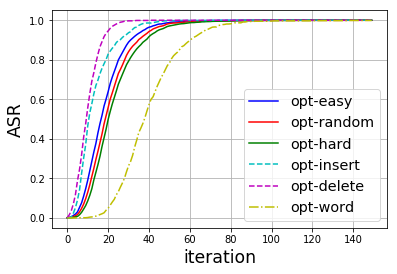

In [618]:
font_name = 'Arial'
line_style = ['b', 'r', 'g', 'c--', 'm--', 'y-.']
iteration = 150
x = np.arange(iteration)
plt.grid()
labels = ['easy', 'random', 'hard', 'insert', 'delete', 'word']
for i, case in (enumerate(['easy', 'random', 'hard', 'insert', 'delete', 'replace-full-word'])):
    with open(f'wm_opt_result/{font_name}-{case}.pkl', 'rb') as f:
        (_, adv_txt_list, _, _, _, _) = pickle.load(f)
    total_iter_list = restore_opt_wm[i][4][-1]
    y = np.array(total_iter_list) / len(adv_txt_list)
    plt.plot(x, y[:iteration], line_style[i], label=f'opt-{labels[i]}')
    plt.xlabel("iteration", fontsize='xx-large') 
    plt.ylabel('ASR', fontsize='xx-large')
    plt.legend(loc=4, fontsize='x-large')    #显示图例
plt.savefig('result_pic/wm_opt.eps')

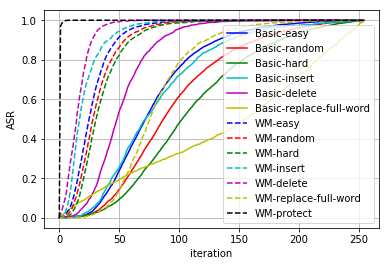

In [297]:
iters = record_iters[1:15]
iteration = max([max(i) for i in iters])
x = np.arange(iteration)
styles = ['b', 'r', 'g', 'c', 'm', 'y', 'b--', 'r--', 'g--', 'c--', 'm--', 'y--', 'k--']
labels = ['Basic-easy', 'Basic-random', 'Basic-hard', 'Basic-insert', 'Basic-delete', 'Basic-replace-full-word'] \
            + ['WM-easy', 'WM-random', 'WM-hard', 'WM-insert', 'WM-delete', 
               'WM-replace-full-word', 'WM-protect']
for record_iter, line_style, label in zip(iters, styles, labels):
    y = np.zeros(iteration)
    for i in record_iter:
        y[x >= i] += 1
    y = y / len(record_iter)
    plt.plot(x, y, line_style, label=label)
    plt.xlabel("iteration") 
    plt.ylabel('ASR')
    plt.legend(loc=4)    #显示图例
    plt.grid()

## horizon plot

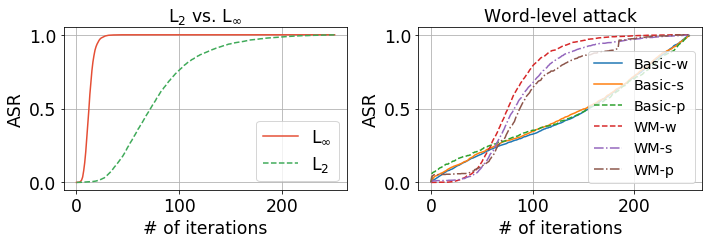

In [2437]:
iters = record_iters[:2]
iteration = max([max(i) for i in iters])
x = np.arange(iteration)
line_styles = ['-', '--']
colors = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, 2))
labels = ['$\mathrm{L_{\infty}}$', '$\mathrm{L_2}$']
plt.figure(figsize=[10, 3.5])
plt.subplot(121)
plt.grid()
for record_iter, color, linestype, label in zip(record_iters[:2], colors, line_styles, labels):
    
    y = np.zeros(iteration)
    for i in record_iter:
        y[x >= i] += 1
    y = y / len(record_iter)
    plt.plot(x, y, color=color, linestyle=linestype, label=label)
    plt.title('$\mathrm{L_2}$ vs. $\mathrm{L_{\infty}}$', fontsize='xx-large')
    plt.xlabel("# of iterations", fontsize='xx-large') 
    plt.ylabel('ASR', fontsize='xx-large')
    plt.legend(loc=4, fontsize='xx-large')    #显示图例
plt.tick_params(labelsize=fsize)
plt.tight_layout()
# plt.savefig('result_pic/l2vslinf.pdf')

iters = sentence_iters
iteration = max([max(i) for i in iters])
x = np.arange(iteration)
line_styles = ['-', '-', '--', '--', '-.', '-.']
colors = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, 6))
labels = ['Basic-w', 'Basic-s', 'Basic-p', 'WM-w', 'WM-s', 'WM-p']
plt.subplot(122)
plt.grid()
for record_iter, color, linestyle, label in zip(sentence_iters, colors, line_styles, labels):
    y = np.zeros(iteration)
    for i in record_iter:
        y[x >= i] += 1
    y = y / len(record_iter)
    plt.plot(x, y, linestyle=linestyle, label=label)
    plt.title('Word-level attack', fontsize='xx-large')
    plt.xlabel("# of iterations", fontsize='xx-large') 
    plt.ylabel('ASR', fontsize='xx-large')
    plt.legend(loc=4, fontsize='x-large')    #显示图例
plt.tick_params(labelsize=fsize)
plt.tight_layout()
# plt.savefig('result_pic/word_attack.pdf')
plt.savefig('result_pic/lp_word_h.pdf')

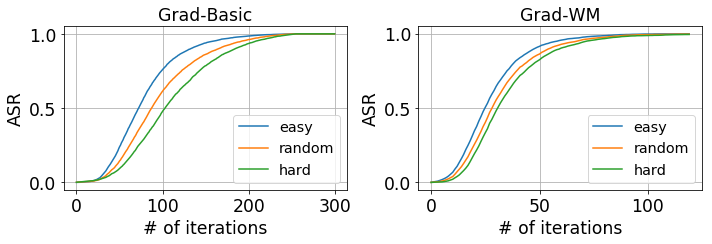

In [2238]:
fsize = 'xx-large'
colors = plt.get_cmap('RdYlGn')(np.linspace(0.0, 1, 6))
plt.figure(figsize=[10, 3.5])

# iters = record_iters[1:6]
iters = record_iters[1:4]
iteration = max([max(i) for i in iters])
iteration = 300
x = np.arange(iteration)
# styles = ['-', '-', '-', '--', '--']
styles = ['-', '-', '-']
# labels = ['easy', 'random', 'hard', 'insert', 'delete']
labels = ['easy', 'random', 'hard']
plt.subplot(121)
plt.grid()
for record_iter, line_style, label in zip(iters, styles, labels):
    y = np.zeros(iteration)
    for i in record_iter:
        y[x >= i] += 1
    y = y / len(record_iter)
    plt.plot(x, y, linestyle=line_style, label=label)
    plt.xlabel("# of iterations", fontsize='xx-large')
    plt.ylabel('ASR', fontsize='xx-large')
    plt.legend(fontsize='x-large')  #显示图例
plt.title('Grad-Basic', fontsize=fsize)
plt.tick_params(labelsize=fsize)
plt.tight_layout()
# plt.savefig('result_pic/basic.eps')

# iters = record_iters[7:12]
iters = record_iters[7:10]
iteration = max([max(i) for i in iters])
iteration = 120
x = np.arange(iteration)
# styles = ['-', '-', '-', '--', '--']
styles = ['-', '-', '-']
# labels = ['easy', 'random', 'hard', 'insert', 'delete']
labels = ['easy', 'random', 'hard']
plt.subplot(122)
plt.grid()
for record_iter, line_style, label in zip(iters, styles, labels):
    y = np.zeros(iteration)
    for i in record_iter:
        y[x >= i] += 1
    y = y / len(record_iter)
    plt.plot(x, y, linestyle=line_style, label=label)
    plt.xlabel("# of iterations", fontsize='xx-large')
    plt.ylabel('ASR', fontsize='xx-large')
    plt.legend(loc=4, fontsize='x-large')  #显示图例
plt.title('Grad-WM', fontsize=fsize)
plt.tick_params(labelsize=fsize)
plt.tight_layout()
plt.savefig('result_pic/grad_h.pdf')

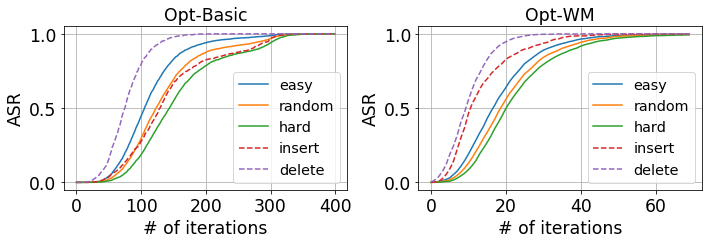

In [2933]:
font_name = 'Arial'
plt.figure(figsize=[10, 3.5])
line_style = ['-', '-', '-', '--', '--']
iteration = 400
x = np.arange(iteration)
plt.subplot(121)
plt.grid()
labels = ['easy', 'random', 'hard', 'insert', 'delete']
cases = ['easy', 'random', 'hard', 'insert', 'delete']
for i, case in (enumerate(cases)):
    with open(f'basic_opt_result/{font_name}-{case}.pkl', 'rb') as f:
        (adv_img, adv_txt_list, adv_l2, adv_iter_list, adv_asr_list, duration) = pickle.load(f)
    total_iter_list = restore_opt[i][4][-1]
    y = np.array(total_iter_list) / len(adv_img)
#     plt.plot(x, y[:iteration], line_style[i], label=f'opt-{labels[i]}')
    plt.plot(x, y[:iteration], linestyle=line_style[i], label=labels[i])
    plt.xlabel("# of iterations", fontsize='xx-large') 
    plt.ylabel('ASR', fontsize='xx-large')
    plt.legend(loc=4, fontsize='x-large')    #显示图例
plt.title('Opt-Basic', fontsize=fsize)
plt.tick_params(labelsize=fsize)
plt.tight_layout()
# plt.savefig('result_pic/basic_opt.eps')

iteration = 70
x = np.arange(iteration)
plt.subplot(122)
plt.grid()
labels = ['easy', 'random', 'hard', 'insert', 'delete']
cases = ['easy', 'random', 'hard', 'insert', 'delete']
for i, case in (enumerate(cases)):
    with open(f'wm_opt_result/{font_name}-{case}.pkl', 'rb') as f:
        (_, adv_txt_list, _, _, _, _) = pickle.load(f)
    total_iter_list = restore_opt_wm[i][4][-1]
    y = np.array(total_iter_list) / len(adv_txt_list)
#     plt.plot(x, y[:iteration], line_style[i], label=f'opt-{labels[i]}')
    plt.plot(x, y[:iteration], linestyle=line_style[i], label=labels[i])
    plt.xlabel("# of iterations", fontsize='xx-large') 
    plt.ylabel('ASR', fontsize='xx-large')
    plt.legend(loc=4, fontsize='x-large')    #显示图例
plt.title('Opt-WM', fontsize=fsize)
plt.tick_params(labelsize=fsize)
plt.tight_layout()
# plt.savefig('result_pic/wm_opt.eps')
# plt.savefig('result_pic/opt_h.pdf')

# sample image

In [1441]:
save_path = 'sample_images_calamari/sample_img'

In [1438]:
font = fonts[4]
lp = '2'
eps_iter = '5.0'

In [2051]:
case = 'easy'
# case = 'hard'
# case = 'replace-full-word'
# idx = 80 # replace, year->hear
# case = 'delete'
# idx = 48 # delete, short->sort
# case = 'insert'
# idx = 13 # insert, here->there
# case = 'replace-full-word'
# idx = 73 # replace-full-word, tennis->amazon
# idx = 16 # replace-full-word, entry->waken
# idx = 24 # replace-full-word, bombed->clouds
width = 140

In [2248]:
with open(f'{img_data_path}/{font}-{case}.pkl', 'rb') as f:
    img_list, input_img, len_x, gt_txt, target_txt = pickle.load(f)

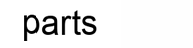

In [2250]:
show(input_img[22])

In [2053]:
# for i, t in enumerate(zip(gt_txt, target_txt)):
#     print(i, t)

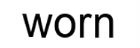

In [2054]:
show(input_img[idx][:width, :])

In [2060]:
idx = sort_idx[0]
target_t = target_txt[idx]

In [2028]:
method = 'grad-basic'
with open(f'sample_images_calamari/{method}-{font}-{case}-l{lp}-eps0.2-ieps{eps_iter}-iter1000.pkl', 'rb') as f:
    adv_img, record_adv_text, record_iter, _ = pickle.load(f)

In [2014]:
show(input_img[idx][:width, :]).save(f'{save_path}/sample-original-{hard_record_adv_text[idx]}.jpg', quality=100)

In [2015]:
target_t = hard_record_adv_text[idx]

In [2016]:
print(hard_record_adv_text[idx])

there


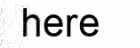

In [2017]:
show(hard_adv_img[idx][:width, :])

In [2018]:
show(hard_adv_img[idx][:width, :]).save(f'{save_path}/sample-{method}-{target_t}.jpg', quality=100)

In [2200]:
# case = 'easy'
# case = 'hard'
case = 'replace-full-word'

In [2201]:
with open(f'{img_data_path}/{font}-{case}.pkl', 'rb') as f:
    img_list, input_img, len_x, gt_txt, target_txt = pickle.load(f)

In [2202]:
method = f'grad-wm'
with open(f'sample_images_calamari/{method}-{font}-{case}-l2-eps0.2-ieps5.0-iter1000.pkl', 'rb') as f:
    (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, wm_adv_img, record_adv_text, record_iter, (duration, total_iter), rgb_img) = pickle.load(f)

In [2203]:
mse = np.array([compare_mse(wm0_img[i], wm_adv_img[i]) for i in range(500)])
sort_idx = np.argsort(mse)
target_txt = [target_txt[i] for i in sort_idx]
gt_txt = [gt_txt[i] for i in sort_idx]

In [2204]:
for i, t in enumerate(zip(gt_txt, target_txt)):
    print(i, t)

0 ('god', 'gds')
1 ('big', 'bab')
2 ('but', 'utu')
3 ('run', 'tef')
4 ('dog', 'aug')
5 ('just', 'iuds')
6 ('two', 'iao')
7 ('his', 'ria')
8 ('ram', 'tay')
9 ('knew', 'lean')
10 ('one', 'rel')
11 ('jim', 'dah')
12 ('during', 'tangie')
13 ('again', 'gaits')
14 ('grim', 'gila')
15 ('cue', 'jet')
16 ('flag', 'cine')
17 ('fan', 'aby')
18 ('kid', 'cia')
19 ('may', 'lys')
20 ('imp', 'gcd')
21 ('till', 'ibis')
22 ('gwen', 'ufos')
23 ('notch', 'enhat')
24 ('joel', 'mash')
25 ('man', 'dkl')
26 ('dev', 'hav')
27 ('rob', 'tow')
28 ('ways', 'hast')
29 ('broad', 'raghu')
30 ('oscar', 'caryl')
31 ('pity', 'ahey')
32 ('max', 'aeq')
33 ('warm', 'heir')
34 ('bonus', 'boise')
35 ('silly', 'filet')
36 ('boy', 'hau')
37 ('sing', 'blue')
38 ('making', 'anenst')
39 ('toy', 'ido')
40 ('good', 'avos')
41 ('word', 'conf')
42 ('gay', 'zan')
43 ('life', 'iced')
44 ('look', 'clog')
45 ('final', 'fario')
46 ('your', 'paar')
47 ('unity', 'bumpy')
48 ('ray', 'fie')
49 ('leads', 'adept')
50 ('film', 'taar')
51 ('das',

In [2219]:
k = 69
idx = sort_idx[k]
target_t = target_txt[k]
print(target_t)

add


In [2243]:
gt_txt.index('parts')

223

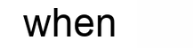

In [2192]:
width = 140

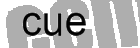

In [2209]:
show(wm0_img[idx][:width, :])

In [2142]:
show(wm0_img[idx][:width, :]).save(f'{save_path}/sample-wm0-{target_t}.jpg', quality=100)

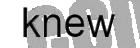

In [2207]:
show(wm_adv_img[idx][:width, :])

In [2144]:
show(wm_adv_img[idx][:width, :]).save(f'{save_path}/sample-{method}-{target_t}.jpg', quality=100)

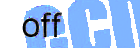

In [2220]:
gray_img = np.array(cvt2Image(1 - wm_adv_img[idx].T).convert('L')) / 255
op_mask = (wm_mask[idx].T) & (~text_mask[idx].T) # not_bg & not_text

rgb_img = np.ones(list(gray_img.shape) + [3])
rgb_img[:, :, 0] = gray_img
rgb_img[:, :, 1] = gray_img
rgb_img[:, :, 2] = gray_img
r = 0.5 # 1.0 0.5 1.0 0.5 1.0 0.5
b = 1.0 # 0.0 0.0 0.5 0.5 1.0 1.0
rgb_img[op_mask, 0] = r
rgb_img[op_mask, 1] = (gray_img[op_mask] - 0.299 * r - 0.114 * b) / 0.587
rgb_img[op_mask, 2] = b

Image.fromarray((rgb_img[:, :width, :] * 255).astype('uint8'))

In [2122]:
Image.fromarray((rgb_img[:, :width, :] * 255).astype('uint8')).save(f'{save_path}/sample-color-{target_t}-r{10*r:.2f}-b{10*b:.2f}.jpg', quality=100)

In [2001]:
method = 'opt-basic'
with open(f'sample_images_calamari/{method}-{font}-{case}.pkl', 'rb') as f:
    (opt_adv_img, adv_txt_list, adv_l2, adv_iter_list, adv_asr_list, duration) = pickle.load(f)

In [2002]:
idx = adv_txt_list.index(target_t)

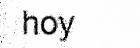

In [2003]:
show(opt_adv_img[idx][:width, :])

In [2004]:
show(opt_adv_img[idx][:width, :]).save(f'{save_path}/sample-{method}-{target_t}.jpg', quality=100)

In [2005]:
method = f'opt-wm'
with open(f'sample_images_calamari/{method}-{font}-{case}.pkl', 'rb') as f:
    (opt_wm_adv_img, adv_txt_list, adv_l2, adv_iter_list, adv_asr_list, duration) = pickle.load(f)

In [2006]:
idx = adv_txt_list.index(target_t)

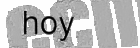

In [2007]:
show(opt_wm_adv_img[idx][:width, :])

In [2008]:
show(opt_wm_adv_img[idx][:width, :]).save(f'{save_path}/sample-{method}-{target_t}.jpg', quality=100)

In [2997]:
len(target_txt)

4824

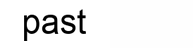

In [3013]:
show(input_img[target_txt.index('part')])

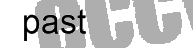

In [3004]:
show(wm0_img[target_txt.index('part')])

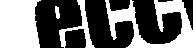

In [3005]:
show(wm_mask[target_txt.index('part')])

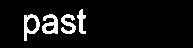

In [3007]:
show(~text_mask[target_txt.index('part')])

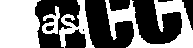

In [3006]:
a = wm_mask[target_txt.index('part')]
b = text_mask[target_txt.index('part')]
show(a * ~b)

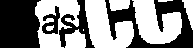

In [3014]:
show(~(a * ~b))

In [3025]:
wm0_img[target_txt.index('part')]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.31764706, 0.31764706, 0.31764706, ..., 0.        , 0.        ,
        0.        ],
       [0.31764706, 0.31764706, 0.31764706, ..., 0.        , 0.        ,
        0.        ],
       [0.31764706, 0.31764706, 0.31764706, ..., 0.        , 0.        ,
        0.        ]])

In [3020]:
1 - 174 / 255

0.3176470588235294

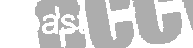

In [3026]:
show((a * ~b)*0.31764706)

In [3091]:
method = f'grad-basic'
font = 'Arial'
lp = 2
eps_iter = 5.0
case = 'easy'
with open(f'sample_images_calamari/{method}-{font}-{case}-l{lp}-eps0.2-ieps{eps_iter}-iter1000.pkl', 'rb') as f:
    easy_adv_img, easy_record_adv_text, record_iter, (duration, total_iter) = pickle.load(f)

case = 'random'
with open(f'sample_images_calamari/{method}-{font}-{case}-l{lp}-eps0.2-ieps{eps_iter}-iter1000.pkl', 'rb') as f:
    random_adv_img, random_record_adv_text, record_iter, (duration, total_iter) = pickle.load(f)

case = 'hard'
with open(f'sample_images_calamari/{method}-{font}-{case}-l{lp}-eps0.2-ieps{eps_iter}-iter1000.pkl', 'rb') as f:
    hard_adv_img, hard_record_adv_text, record_iter, (duration, total_iter) = pickle.load(f)

In [3092]:
for i, txt in enumerate(zip(easy_record_adv_text, random_record_adv_text, hard_record_adv_text)):
    print(i, txt)

0 ('foy', 'foy', 'joy')
1 ('tay', 'tuy', 'thy')
2 ('tor', 'toi', 'toa')
3 ('spates', 'slates', 'skates')
4 ('stanes', 'stapes', 'stases')
5 ('status', 'status', 'status')
6 ('stater', 'stated', 'stated')
7 ('ophion', 'ophion', 'opaion')
8 ('fandom', 'fandom', 'mandom')
9 ('ransom', 'ransom', 'ransom')
10 ('randem', 'randem', 'randem')
11 ('randon', 'randon', 'randon')
12 ('cod', 'nod', 'hod')
13 ('ged', 'gid', 'gld')
14 ('goo', 'goy', 'goy')
15 ('stript', 'stript', 'stript')
16 ('scrips', 'scrips', 'scrips')
17 ('disert', 'disert', 'disert')
18 ('shrill', 'shrill', 'shrill')
19 ('thrall', 'thrall', 'thrall')
20 ('las', 'fas', 'pas')
21 ('des', 'dis', 'dys')
22 ('dae', 'dak', 'dab')
23 ('resalt', 'resalt', 'resalt')
24 ('resuit', 'resuit', 'resuit')
25 ('tarry', 'parry', 'jarry')
26 ('curry', 'curry', 'curry')
27 ('carty', 'carey', 'carby')
28 ('carrs', 'carri', 'carri')
29 ('hid', 'fid', 'qid')
30 ('ked', 'ked', 'kyd')
31 ('kie', 'kil', 'kip')
32 ('whats', 'ghats', 'khats')
33 ('teats'

In [1927]:
show(easy_adv_img[i]).save(
    f'{save_path}/{method}-{font}-easy-l{lp}-ieps{eps_iter}-{easy_record_adv_text[i]}.jpg',
    quality=100)
show(random_adv_img[i]).save(
    f'{save_path}/{method}-{font}-random-l{lp}-ieps{eps_iter}-{random_record_adv_text[i]}.jpg',
    quality=100)
show(hard_adv_img[i]).save(
    f'{save_path}/{method}-{font}-hard-l{lp}-ieps{eps_iter}-{hard_record_adv_text[i]}.jpg',
    quality=100)

In [1928]:
method = f'grad-wm'
case = 'word'
with open(f'sample_images_calamari/{method}-{font}-{case}-l2-eps0.2-ieps5.0-iter1000.pkl', 'rb') as f:
    (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, adv_img, record_adv_text, record_iter, (duration, total_iter), rgb_img) = pickle.load(f)

In [3093]:
method = f'opt-basic'
case = 'delete'
with open(f'sample_images_calamari/{method}-{font}-{case}.pkl', 'rb') as f:
    (adv_img, adv_txt_list, adv_l2, adv_iter_list, adv_asr_list, duration) = pickle.load(f)

In [1930]:
method = f'opt-wm'
case = 'delete'
with open(f'sample_images_calamari/{method}-{font}-{case}.pkl', 'rb') as f:
    (adv_img, adv_txt_list, adv_l2, adv_iter_list, adv_asr_list, duration) = pickle.load(f)

In [1931]:
for i, txt in enumerate(record_adv_text[:100]):
    print(i, txt)

0 Hep sign of a good movie is that it can toy with our emotions.
1 Tale one did exactly that.
2 He is beep on his way to having leading-man status.
3 Fmt many movies are there that you can think of when you see a movie like this?
4 Cloak borrowing so much from other movies it never goes overboard.
5 Costner carries vim movie swimmingly with the best of Costner's ability.
6 Thob movie was sadly under-promoted but proved to be truly exceptional.
7 Cum weaker parts of the movie revolve largely around using stereotypical set scenes.
8 Coker were only a few scenes that were far fetched.
9 Swimmers eon not allowed to go inside of any vessel no matter the circumstances.
10 Cpt her presence on screen is a pleasure.
11 Pwt two unaccredited stars of this movie are the Coast Guard and the Sea.
12 Ulan powerful forces which should not be taken for granted in real life or this movie.
13 Soir movie earns the audience applause.
14 However, I rowt the theatre feeling unsatisfied.
15 Tanbur Kutcher can

Waggy Smits, terrific, and doesn't try to pull focus because he's a star.


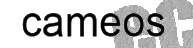

In [1932]:
i = 45
# print(easy_record_adv_text[i])
# show(easy_adv_img[i])
# print(random_record_adv_text[i])
# show(random_adv_img[i])
# print(hard_record_adv_text[i])
# show(hard_adv_img[i])
# print(adv_txt_list[i])
print(record_adv_text[i])
show(adv_img[i])

In [1933]:
# long attack wm
show(adv_img[i]).save(
    f'{save_path}/non-overlap-{font}-{record_adv_text[i]}.jpg',
    quality=100)

In [879]:
# grad
show(adv_img[i]).save(
    f'{save_path}/{method}-{font}-{case}-l{lp}-ieps{eps_iter}-{record_adv_text[i]}.jpg',
    quality=100)

In [859]:
# opt
show(adv_img[i]).save(
    f'{save_path}/{method}-{font}-{case}-l{lp}-ieps{eps_iter}-{adv_txt_list[i]}.jpg',
    quality=100)

In [927]:
for font in fonts[4:5]:
    with open(f'long_attack_result/{font}-easy-l2-eps0.2-ieps5.0-iter2000.pkl',
              'rb') as f:
        (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, adv_img,
         record_adv_text, record_iter, (duration,
                                        total_iter), rgb_img) = pickle.load(f)
    print(font)
    try:
        i = record_adv_text[:100].index('bread')
        show(adv_img[i]).save(
            f'{save_path}/non-overlap-{font}-{record_adv_text[i]}.jpg',
            quality=100)
    except:
        continue

Arial


In [907]:
with open('sample_images_calamari/Georgia-easy-l2-eps0.2-ieps5.0-iter1000.pkl', 'rb') as f:
    (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, adv_img,
         record_adv_text, record_iter, (duration,
                                        total_iter), rgb_img) = pickle.load(f)

In [926]:
for i, txt in enumerate(zip(record_adv_text, record_text)):
    print(i, txt)

0 ('foy', 'toy')
1 ('toy', 'toy')
2 ('tor', 'toy')
3 ('states', 'states')
4 ('states', 'states')
5 ('states', 'states')
6 ('stater', 'states')
7 ('option', 'option')
8 ('fandom', 'random')
9 ('random', 'random')
10 ('random', 'random')
11 ('randon', 'random')
12 ('god', 'god')
13 ('god', 'god')
14 ('god', 'god')
15 ('script', 'script')
16 ('script', 'script')
17 ('disert', 'desert')
18 ('thrill', 'thril')
19 ('thrill', 'thrill')
20 ('das', 'das')
21 ('des', 'das')
22 ('dae', 'das')
23 ('result', 'result')
24 ('result', 'result')
25 ('carry', 'carry')
26 ('curry', 'carry')
27 ('carty', 'carry')
28 ('carry', 'carry')
29 ('hid', 'kid')
30 ('kid', 'kid')
31 ('kid', 'kid')
32 ('whats', 'thats')
33 ('teats', 'thats')
34 ('thats', 'thats')
35 ('thatd', 'thats')
36 ('bere', 'here')
37 ('hare', 'here')
38 ('here', 'here')
39 ('hera', 'here')
40 ('texas', 'texas')
41 ('texts', 'texas')
42 ('texas', 'texas')
43 ('shaft', 'shaft')
44 ('shift', 'shaft')
45 ('shaft', 'shaft')
46 ('entrye', 'entry')


862 ('lived', 'lived ')
863 ('lined', 'lived ')
864 ('lived', 'lived')
865 ('liver', 'lived')
866 ('pushed', 'pushed')
867 ('pashed', 'pushed')
868 ('pusher', 'pushed ')
869 ('say', 'gay')
870 ('gey', 'gay')
871 ('gay', 'gay')
872 ('figure', 'figure')
873 ('figure', 'figure')
874 ('figure', 'figure')
875 ('dog', 'dog')
876 ('dog', 'dog')
877 ('dog', 'dog')
878 ('chills', 'chills')
879 ('chils', 'chills')
880 ('chills', 'chills')
881 ('chills', 'chills')
882 ('man', 'man')
883 ('men', 'man')
884 ('mar', 'man')
885 ('ery', 'very')
886 ('vary', 'very')
887 ('veny', 'very')
888 ('very', 'very')
889 ('pacing', 'pacimg')
890 ('paling', 'pacing')
891 ('ready', 'ready ')
892 ('reedy', 'ready')
893 ('ready', 'ready')
894 ('readd', 'ready')
895 ('stole', 'stole')
896 ('stole', 'stole')
897 ('stele', 'stole')
898 ('stole', 'stole')
899 ('stola', 'stole')
900 ('sunday', 'sunday')
901 ('sundey', 'sunday')
902 ('sunday', 'sunday')
903 ('stars', 'stars')
904 ('stirs', 'stars')
905 ('stars', 'stars')


1774 ('fails', 'fails')
1775 ('fails', 'fails')
1776 ('fails', 'fails')
1777 ('neet', 'meet')
1778 ('met', 'meet')
1779 ('mest', 'meet')
1780 ('meer', 'meet')
1781 ('pell', 'well')
1782 ('wall', 'well')
1783 ('well', 'well')
1784 ('welf', 'well')
1785 ('prince', 'prince')
1786 ('prince', 'prince')
1787 ('enow', 'know')
1788 ('knew', 'knowl')
1789 ('knob', 'know')
1790 ('where', 'there ')
1791 ('tsere', 'there')
1792 ('there', 'there')
1793 ('there', 'there')
1794 ('there', 'there')
1795 ('faired', 'faired')
1796 ('faired', 'faired')
1797 ('faired', 'faired')
1798 ('faired', 'faired')
1799 ('glaire', 'claire ')
1800 ('claire', 'claire')
1801 ('ith', 'with')
1802 ('with', 'with')
1803 ('with', 'with')
1804 ('wite', 'with')
1805 ('redia', 'media')
1806 ('media', 'media')
1807 ('media', 'media')
1808 ('media', 'media')
1809 ('medii', 'media')
1810 ('steals', 'steals')
1811 ('steels', 'steals')
1812 ('steaks', 'steals')
1813 ('stealsy', 'steals')
1814 ('point', 'point')
1815 ('point', 'poin

2910 ('korean', 'korean')
2911 ('fresh', 'fresh')
2912 ('frosh', 'fresh')
2913 ('fress', 'fresh')
2914 ('magic', 'magic-')
2915 ('seeing', 'seeing')
2916 ('seeing', 'seeing ')
2917 ('lately', 'lately ')
2918 ('lately', 'lately')
2919 ('croft', 'croft')
2920 ('croft', 'croft')
2921 ('croft', 'croft')
2922 ('fun', 'fun')
2923 ('fun', 'fun')
2924 ('fur', 'fun')
2925 ('ley', 'key')
2926 ('kay', 'key')
2927 ('ker', 'key')
2928 ('loves', 'loves')
2929 ('loves', 'loves')
2930 ('lowes', 'loves')
2931 ('lovee', 'loves')
2932 ('fescue', 'rescue')
2933 ('resoue', 'rescue')
2934 ('ris', 'kris')
2935 ('knis', 'kris')
2936 ('kris', 'kris')
2937 ('virion', 'vision')
2938 ('forked', 'worked')
2939 ('worked', 'worked')
2940 ('worded', 'worked')
2941 ('worker', 'worked')
2942 ('nother', 'mother')
2943 ('mother', 'mother')
2944 ('mothed', 'mother')
2945 ('sion', 'sign')
2946 ('sign', 'sign')
2947 ('oving', 'moving')
2948 ('moving', 'movng')
2949 ('haughs', 'laughs')
2950 ('laughs', 'laughs')
2951 ('laigh

3774 ('moon', 'moo')
3775 ('moon', 'moon')
3776 ('moor', 'moon')
3777 ('winner', 'winner')
3778 ('winner', 'winner')
3779 ('wiener', 'winner')
3780 ('winer', 'winner')
3781 ('winnel', 'winner')
3782 ('camara', 'camera')
3783 ('camery', 'camera')
3784 ('quilt', 'gultl')
3785 ('guile', 'guilt')
3786 ('facet', 'facet')
3787 ('facet', 'facet')
3788 ('facer', 'facet')
3789 ('any', 'many')
3790 ('meny', 'many')
3791 ('mary', 'many')
3792 ('manyg', 'many')
3793 ('ruined', 'ruined')
3794 ('ruinedr', 'ruined')
3795 ('atter', 'utter')
3796 ('utter', 'utter')
3797 ('utter', 'utter')
3798 ('jon', 'jon')
3799 ('jon', 'jon')
3800 ('jos', 'jon')
3801 ('fans', 'fans')
3802 ('fns', 'fans')
3803 ('fass', 'fans')
3804 ('fans', 'fans')
3805 ('frets', 'frets')
3806 ('frets', 'frets')
3807 ('fress', 'frets')
3808 ('frett', 'frets')
3809 ('scott', 'scott')
3810 ('scott', 'scott')
3811 ('scott', 'scott')
3812 ('scote', 'scott')
3813 ('hames', 'names')
3814 ('nmes', 'names')
3815 ('nanes', 'names')
3816 ('name

In [960]:
case = 'easy'
eps = 0.2
pert_type = 'inf'
eps_iter = 1.0
nb_iter = 1000
method = 'grad-basic'
for font_name in fonts:
# font_name = fonts[0]
    title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
    with open(f'attack_result/{title}.pkl', 'rb') as f:
        adv_img, record_adv_text, _, _ = pickle.load(f)
    i = record_adv_text.index('ports')
    show(adv_img[i]).save(f'{save_path}/{record_adv_text[i]}-{method}-{font_name}-{case}-l{pert_type}-ieps{int(eps_iter)}.jpg')

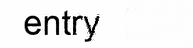

In [1015]:
show(adv_img[10])

In [2374]:
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/word_image_data'
font_name = 'Arial'
case = 'insert'
nb_iter = 2000
title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"

In [2375]:
with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
    img_list, input_img, len_x, gt_txt, target_txt = pickle.load(f)

In [2376]:
with open(f'attack_result/{title}.pkl', 'rb') as f:
    adv_img, record_adv_text, record_iter, (duration, total_iter) = pickle.load(f)

In [2377]:
with open(f'wm_result/{title}.pkl', 'rb') as f:
    (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, wm_adv_img, record_adv_text, record_iter, (duration, total_iter), rgb_img) = pickle.load(f)

In [2391]:
with open(f'sample_images_calamari/grad-basic-{title}.pkl', 'rb') as f:
    (full_adv_img, record_adv_text, record_iter, (duration, i)) = pickle.load(f)

ValueError: too many values to unpack (expected 4)

In [2426]:
with open(f'sample_images_calamari/grad-wm-Arial-delete-l2-eps0.2-ieps5.0-iter1000.pkl', 'rb') as f:
    (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, wm_adv_img, record_adv_text, record_iter, (duration, total_iter), rgb_img) = pickle.load(f)

In [2434]:
with open(f'sample_images_calamari/grad-wm-Arial-insert-l2-eps0.2-ieps5.0-iter1000.pkl', 'rb') as f:
    (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, wm_adv_img, record_adv_text, record_iter, (duration, total_iter), rgb_img) = pickle.load(f)

In [1374]:
full_img = input_img[idx].copy()
full_img[full_img < 0.1] = 0.31764706

In [2266]:
for i, t in enumerate(zip(gt_txt, target_txt, d_target_txt)):
    print(i, t)

0 ('toy', 'tony', 'to')
1 ('states', 'staters', 'stats')
2 ('option', 'options', 'optio')
3 ('random', 'randoms', 'rando')
4 ('god', 'gods', 'gd')
5 ('script', 'escript', 'scrip')
6 ('desert', 'dessert', 'deser')
7 ('thrill', 'thrilly', 'thill')
8 ('das', 'days', 'ds')
9 ('result', 'results', 'resul')
10 ('carry', 'carrys', 'cary')
11 ('kid', 'kind', 'id')
12 ('thats', 'thatsa', 'tats')
13 ('here', 'there', 'ere')
14 ('texas', 'texans', 'teas')
15 ('shaft', 'shafty', 'haft')
16 ('entry', 'centry', 'entr')
17 ('wives', 'swives', 'wive')
18 ('broad', 'byroad', 'brod')
19 ('roman', 'romane', 'roan')
20 ('making', 'makings', 'aking')
21 ('pages', 'pagnes', 'page')
22 ('parts', 'partis', 'pars')
23 ('bombed', 'bombeda', 'bombe')
24 ('hoy', 'hoys', 'hy')
25 ('taped', 'tamped', 'aped')
26 ('year', 'yeard', 'ear')
27 ('lambs', 'lambes', 'labs')
28 ('hockey', 'hockeys', 'hokey')
29 ('where', 'whered', 'were')
30 ('move', 'amove', 'moe')
31 ('also', 'aliso', 'alo')
32 ('love', 'clove', 'loe')
33

1031 ('andre', 'andrea', 'anre')
1032 ('proved', 'provend', 'prove')
1033 ('ignore', 'ignores', 'ignor')
1034 ('falls', 'fallsa', 'fall')
1035 ('alarm', 'alarum', 'alar')
1036 ('sexier', 'sexiera', 'sexie')
1037 ('such', 'subch', 'sch')
1038 ('front', 'afront', 'font')
1039 ('bank', 'blank', 'ban')
1040 ('blends', 'blendes', 'lends')
1041 ('gene', 'genre', 'gee')
1042 ('nice', 'unice', 'ice')
1043 ('act', 'fact', 'ac')
1044 ('some', 'somne', 'soe')
1045 ('inside', 'insides', 'insid')
1046 ('video', 'videos', 'ideo')
1047 ('bruce', 'brucea', 'bruc')
1048 ('fall', 'fally', 'fll')
1049 ('mum', 'mulm', 'mu')
1050 ('pieces', 'apieces', 'piece')
1051 ('dinner', 'dinners', 'inner')
1052 ('right', 'wright', 'righ')
1053 ('exist', 'sexist', 'exit')
1054 ('down', 'adown', 'don')
1055 ('brave', 'braved', 'brae')
1056 ('ensue', 'ensues', 'ense')
1057 ('curtis', 'curitis', 'cutis')
1058 ('bit', 'obit', 'bi')
1059 ('moment', 'moments', 'momen')
1060 ('taste', 'tastes', 'tate')
1061 ('blade', 'bladed

In [2417]:
# print(compare_mse((1 - adv_img[idx].T)*255, (1 - input_img[idx].T)*255))
# print(compare_mse((1 - full_img.T)*255, (1 - full_adv_img[idx].T)*255))
print(compare_mse((1 - wm0_img[idx].T)*255, (1 - wm_adv_img[idx].T)*255))

14.735155966482093


In [2435]:
imga = (1 - wm0_img[idx]) * 255
imgb = (1 - wm_adv_img[idx]) * 255
a = ((imga - imgb))
print(np.mean(a ** 2))
a = ((imga - imgb) * ((imga - imgb) > 0))
print(np.mean(a ** 2))
a = ((imga - imgb) * ((imga - imgb) < 0))
print(np.mean(a ** 2))

14.735155966482093
7.098164978183052
7.636990988299039


In [2396]:
idx=22

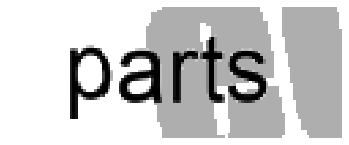

In [2429]:
plt.axis('off')
plt.xticks([])
plt.yticks([])
# plt.imshow(1 - input_img[idx][shift:width+shift, :].T, cmap='gray')
# plt.imshow(1 - adv_img[idx][shift:width+shift, :].T, cmap='gray')

# plt.imshow(1 - full_img.T, cmap='gray')
# plt.imshow(1 - full_adv_img[idx][shift:width+shift, :].T, cmap='gray')

plt.imshow(1 - wm0_img[idx][shift:width+shift, :].T, cmap='gray')
# plt.imshow(1 - wm_adv_img[idx][shift:width+shift, :].T, cmap='gray')

In [2324]:
width = 123
shift = 1

In [2398]:
plt.imsave('result_pic/delete-pars.jpg', 1 - d_wm_adv_img[idx][shift:width+shift, :].T, cmap='gray')

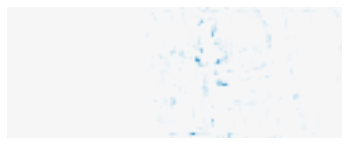

In [2432]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# x = (adv_img[idx][shift:width+shift, :]-input_img[idx][shift:width+shift, :]).T
# x = (adv_img[idx][shift:width+shift, :]-input_img[idx][shift:width+shift, :]).T * ((adv_img[idx][shift:width+shift, :]-input_img[idx][shift:width+shift, :]) > 0).T
# x = (adv_img[idx][shift:width+shift, :]-input_img[idx][shift:width+shift, :]).T * ((adv_img[idx][shift:width+shift, :]-input_img[idx][shift:width+shift, :]) < 0).T

# x = (wm0_img[idx][shift:width+shift, :] - wm_adv_img[idx][shift:width+shift, :]).T
# x = (wm0_img[idx][shift:width+shift, :] - wm_adv_img[idx][shift:width+shift, :]).T * ((wm0_img[idx][shift:width+shift, :] - wm_adv_img[idx][shift:width+shift, :]) > 0).T
x = (wm0_img[idx][shift:width+shift, :] - wm_adv_img[idx][shift:width+shift, :]).T * ((wm0_img[idx][shift:width+shift, :] - wm_adv_img[idx][shift:width+shift, :]) < 0).T

# x = (full_adv_img[idx][shift:width+shift, :] - full_img).T
# x = (full_adv_img[idx][shift:width+shift, :] - full_img).T * ((full_adv_img[idx][shift:width+shift, :] - full_img) > 0).T
# x = (full_adv_img[idx][shift:width+shift, :] - full_img).T * ((full_adv_img[idx][shift:width+shift, :] - full_img) < 0).T

plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.imshow(
    x,
    #            cmap=cm.RdYlGn,
    #            cmap=cm.coolwarm,
    cmap='RdBu_r',
    #            cmap='gray',
    interpolation='bilinear',
    vmin=-0.2,
    vmax=0.2,
)

In [1024]:
import cv2

In [1046]:
src = (np.abs(adv_img[10]-input_img[10]) > 5e-2) * 255.0
kernel = np.ones((3, 3), np.uint8)  # 设置卷积核3*3
dilate = cv2.dilate(src, kernel, iterations=2)  # 图像的膨胀
erode = cv2.erode(dilate, kernel, iterations=2)  # 图像的腐蚀

In [1049]:
from skimage import morphology

In [1058]:
remove = morphology.remove_small_objects(erode.astype('bool'), min_size=64)

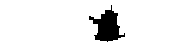

In [1059]:
show(remove)

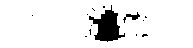

In [1047]:
show(erode)

In [1178]:
with open(f'sample_images_calamari/grad-wm-{title}.pkl', 'rb') as f:
    (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, adv_img, record_adv_text, record_iter, (duration, total_iter), rgb_img) = pickle.load(f)

In [1068]:
wm_img = Image.open('wm_img.jpg').convert('L')

In [1134]:
gray_img = np.array(cvt2Image(1 - adv_img[10].T).convert('L')) / 255
op_mask = (wm_mask[10].T) & (~text_mask[10].T) # not_bg & not_text

In [1135]:
gray_img = np.array(cvt2Image(1 - adv_img[10].T).convert('L')) / 255
op_mask = (wm_mask[10].T) & (~text_mask[10].T) # not_bg & not_text

rgb_img = np.ones(list(gray_img.shape) + [3])
rgb_img[:, :, 0] = gray_img
rgb_img[:, :, 1] = gray_img
rgb_img[:, :, 2] = gray_img
r = 1
b = 0
rgb_img[op_mask, 0] = r
rgb_img[op_mask, 1] = (gray_img[op_mask] - 0.299 * r - 0.114 * b) / 0.587
rgb_img[op_mask, 2] = b

Image.fromarray((rgb_img * 255).astype('uint8'))

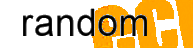

In [1136]:
Image.fromarray((rgb_img * 255).astype('uint8'))

In [1100]:
gray_img = np.array(cvt2Image(adv_img[10]).convert('L'))
op_mask = (~(gray_img == 255)) & (text_mask[10]) # not_bg & not_text
rgb_img = np.array(Image.fromarray(gray_img).convert('RGB'))
rgb_img[op_mask, 0] = 255
rgb_img[op_mask, 1] = np.clip(((1000 * gray_img[op_mask] - 255 * 299) / 587).astype('uint8'), 0, 255)
rgb_img[op_mask, 2] = 0

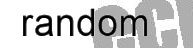

In [1185]:
text_img = show(input_img[10])
text_mask = get_text_mask(np.array(text_img))  # 得到 text 的 mask(bool)
rgb_img = Image.new(mode="RGB", size=text_img.size, color=(255, 255, 255))
p = -int(wm_img.size[0] * np.tan(10 * np.pi / 180))
right_shift = 0
xp = 85
rgb_img.paste(wm_img, box=(xp, p))  # 先贴 wm
wm_mask = (np.array(rgb_img.convert('L')) != 255)  # 得到 wm 的 mask(bool)
rgb_img.paste(text_img, mask=cvt2Image(text_mask))  # 再贴 text
rgb_img

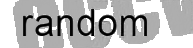

In [1061]:
show(adv_img[10])

In [ ]:
pert = np.abs(cvt2raw(adv_img) - cvt2raw(input_img))
pert = (pert > 1e-2) * 255.0
wm_pos_list = []
frame_img_list = []
for src in pert:
    kernel = np.ones((3, 3), np.uint8)  # 设置卷积核3*3
    dilate = cv2.dilate(src, kernel, iterations=2)  # 图像的膨胀
    erode = cv2.erode(dilate, kernel, iterations=2)  # 图像的腐蚀
    remove = morphology.remove_small_objects(erode.astype('bool'), min_size=0)
    contours, _ = cv2.findContours((remove * 255).astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    wm_pos, frame_img = [], []
    for cont in contours:
        left_point = cont.min(axis=1).min(axis=0)
        right_point = cont.max(axis=1).max(axis=0)
        wm_pos.append(np.hstack((left_point, right_point)))
        if ret_frame_img:
            img = cv2.rectangle(
                (remove * 255).astype('uint8'), (left_point[0], left_point[1]),
                (right_point[0], right_point[1]), (255, 255, 255), 2)
            frame_img.append(img)
    wm_pos_list.append(wm_pos)
    frame_img_list.append(frame_img)

# example table

In [1407]:
case = 'hard'
font_name = 'Arial'
pert_type, eps_iter = '2', 5.0

In [1409]:
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/word_image_data'

In [1410]:
with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
    img_list, input_img, len_x, gt_txt, target_txt = pickle.load(f)

In [1415]:
for i, t in enumerate(zip(gt_txt, target_txt)):
    print(i, t)

0 ('toy', 'joy')
1 ('toy', 'thy')
2 ('toy', 'toa')
3 ('states', 'skates')
4 ('states', 'stases')
5 ('states', 'status')
6 ('states', 'stated')
7 ('option', 'opaion')
8 ('random', 'mandom')
9 ('random', 'ransom')
10 ('random', 'randem')
11 ('random', 'randon')
12 ('god', 'hod')
13 ('god', 'gld')
14 ('god', 'goy')
15 ('script', 'stript')
16 ('script', 'scrips')
17 ('desert', 'disert')
18 ('thrill', 'shrill')
19 ('thrill', 'thrall')
20 ('das', 'pas')
21 ('das', 'dys')
22 ('das', 'dab')
23 ('result', 'resalt')
24 ('result', 'resuit')
25 ('carry', 'jarry')
26 ('carry', 'curry')
27 ('carry', 'carby')
28 ('carry', 'carri')
29 ('kid', 'qid')
30 ('kid', 'kyd')
31 ('kid', 'kip')
32 ('thats', 'khats')
33 ('thats', 'twats')
34 ('thats', 'thaws')
35 ('thats', 'thatn')
36 ('here', 'jere')
37 ('here', 'hure')
38 ('here', 'hewe')
39 ('here', 'hery')
40 ('texas', 'tepas')
41 ('texas', 'texts')
42 ('texas', 'texan')
43 ('shaft', 'chaft')
44 ('shaft', 'shift')
45 ('shaft', 'shalt')
46 ('entry', 'entre')


776 ('smart', 'smalt')
777 ('smart', 'smarm')
778 ('ben', 'jen')
779 ('ben', 'bun')
780 ('ben', 'bec')
781 ('flaw', 'claw')
782 ('flaw', 'flow')
783 ('flaw', 'flak')
784 ('viewed', 'viewer')
785 ('weight', 'height')
786 ('weight', 'wright')
787 ('weight', 'weighs')
788 ('freed', 'creed')
789 ('freed', 'fried')
790 ('freed', 'freud')
791 ('freed', 'frees')
792 ('german', 'herman')
793 ('german', 'gorman')
794 ('german', 'gemman')
795 ('german', 'germon')
796 ('german', 'germal')
797 ('saturn', 'satury')
798 ('nanny', 'canny')
799 ('nanny', 'ninny')
800 ('nanny', 'nancy')
801 ('will', 'kill')
802 ('will', 'wull')
803 ('will', 'wirl')
804 ('will', 'wily')
805 ('stolen', 'stoven')
806 ('stolen', 'stolon')
807 ('stolen', 'stoled')
808 ('field', 'yield')
809 ('field', 'fjeld')
810 ('field', 'fiend')
811 ('spooky', 'spoony')
812 ('spooky', 'spooks')
813 ('old', 'fld')
814 ('old', 'owd')
815 ('old', 'olp')
816 ('john', 'hohn')
817 ('john', 'joon')
818 ('out', 'jut')
819 ('out', 'ort')
820 ('ou

1667 ('more', 'mire')
1668 ('more', 'moue')
1669 ('more', 'morw')
1670 ('ever', 'over')
1671 ('ever', 'emer')
1672 ('ever', 'evea')
1673 ('relief', 'belief')
1674 ('relief', 'relied')
1675 ('loss', 'soss')
1676 ('loss', 'liss')
1677 ('loss', 'lobs')
1678 ('loss', 'losh')
1679 ('bold', 'cold')
1680 ('bold', 'bald')
1681 ('bold', 'bood')
1682 ('bold', 'bolk')
1683 ('keel', 'jeel')
1684 ('keel', 'kiel')
1685 ('keel', 'kell')
1686 ('keel', 'keep')
1687 ('ranges', 'manges')
1688 ('ranges', 'rances')
1689 ('ranges', 'ranged')
1690 ('wrote', 'grote')
1691 ('wrote', 'write')
1692 ('wrote', 'wroke')
1693 ('wrote', 'wroth')
1694 ('dual', 'bual')
1695 ('dual', 'dhal')
1696 ('dual', 'dull')
1697 ('dual', 'duan')
1698 ('famous', 'hamous')
1699 ('famous', 'fumous')
1700 ('famous', 'favous')
1701 ('ago', 'ego')
1702 ('ago', 'aho')
1703 ('ago', 'agr')
1704 ('kevin', 'levin')
1705 ('kevin', 'kevyn')
1706 ('kevin', 'kevil')
1707 ('been', 'veen')
1708 ('been', 'bien')
1709 ('been', 'benn')
1710 ('been', 

2567 ('single', 'singly')
2568 ('stupid', 'stuped')
2569 ('eyes', 'wyes')
2570 ('eyes', 'emes')
2571 ('eyes', 'eyas')
2572 ('eyes', 'eyey')
2573 ('pass', 'jass')
2574 ('pass', 'poss')
2575 ('pass', 'pams')
2576 ('pass', 'pask')
2577 ('comedy', 'comely')
2578 ('comedy', 'comedo')
2579 ('kung', 'qung')
2580 ('kung', 'kong')
2581 ('kung', 'kunk')
2582 ('wait', 'gait')
2583 ('wait', 'writ')
2584 ('wait', 'watt')
2585 ('wait', 'waik')
2586 ('smell', 'skell')
2587 ('smell', 'small')
2588 ('smell', 'smelt')
2589 ('sets', 'jets')
2590 ('sets', 'sits')
2591 ('sets', 'seas')
2592 ('sets', 'seth')
2593 ('hid', 'cid')
2594 ('hid', 'hyd')
2595 ('hid', 'hip')
2596 ('boats', 'goats')
2597 ('boats', 'blats')
2598 ('boats', 'borts')
2599 ('boats', 'boars')
2600 ('girl', 'wirl')
2601 ('girl', 'gurl')
2602 ('girl', 'gill')
2603 ('girl', 'giro')
2604 ('volume', 'volute')
2605 ('shows', 'dhows')
2606 ('shows', 'scows')
2607 ('shows', 'shaws')
2608 ('shows', 'shogs')
2609 ('shows', 'showy')
2610 ('viewer', 

3518 ('chunk', 'crunk')
3519 ('chunk', 'chonk')
3520 ('chunk', 'chuck')
3521 ('chunk', 'chung')
3522 ('set', 'jet')
3523 ('set', 'slt')
3524 ('set', 'sem')
3525 ('order', 'arder')
3526 ('order', 'odder')
3527 ('order', 'ormer')
3528 ('ten', 'jen')
3529 ('ten', 'tln')
3530 ('ten', 'tec')
3531 ('drone', 'prone')
3532 ('drone', 'dione')
3533 ('drone', 'drove')
3534 ('drone', 'drony')
3535 ('tale', 'sale')
3536 ('tale', 'tole')
3537 ('tale', 'tave')
3538 ('tale', 'tall')
3539 ('conrad', 'konrad')
3540 ('conrad', 'conred')
3541 ('stir', 'soir')
3542 ('stir', 'ster')
3543 ('stir', 'stim')
3544 ('jerry', 'kerry')
3545 ('jerry', 'jarry')
3546 ('jerry', 'jewry')
3547 ('jerry', 'jerky')
3548 ('could', 'would')
3549 ('could', 'cauld')
3550 ('room', 'woom')
3551 ('room', 'roam')
3552 ('room', 'rook')
3553 ('gang', 'kang')
3554 ('gang', 'gong')
3555 ('gang', 'garg')
3556 ('gang', 'gant')
3557 ('fellow', 'yellow')
3558 ('fellow', 'follow')
3559 ('fellow', 'fetlow')
3560 ('fellow', 'felloe')
3561 ('t

4517 ('rita', 'dita')
4518 ('rita', 'rota')
4519 ('rita', 'rima')
4520 ('rita', 'ritz')
4521 ('price', 'trice')
4522 ('price', 'prime')
4523 ('price', 'prich')
4524 ('spots', 'shots')
4525 ('spots', 'spits')
4526 ('nurse', 'curse')
4527 ('nurse', 'norse')
4528 ('nurse', 'nursy')
4529 ('evokes', 'evoked')
4530 ('opt', 'rpt')
4531 ('opt', 'oat')
4532 ('opt', 'opa')
4533 ('unfair', 'infair')
4534 ('unfair', 'unhair')
4535 ('unfair', 'unfain')
4536 ('fact', 'bact')
4537 ('fact', 'fict')
4538 ('fact', 'faut')
4539 ('fact', 'facy')
4540 ('rex', 'kex')
4541 ('rex', 'rix')
4542 ('rex', 'reb')
4543 ('find', 'kind')
4544 ('find', 'fend')
4545 ('find', 'fied')
4546 ('find', 'fink')
4547 ('walker', 'calker')
4548 ('walker', 'wacker')
4549 ('walker', 'walter')
4550 ('walker', 'walked')
4551 ('hyped', 'typed')
4552 ('hyped', 'hoped')
4553 ('hyped', 'hypes')
4554 ('slower', 'blower')
4555 ('slower', 'stower')
4556 ('slower', 'sliwer')
4557 ('slower', 'sloper')
4558 ('slower', 'slowed')
4559 ('back', 

In [1430]:
idx = 0

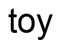

In [1431]:
img_list[idx]

In [1432]:
title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"

In [1436]:
with open(f'sample_images_calamari/grad-basic-{title}.pkl', 'rb') as f:
    adv_img, record_adv_text, record_iter, (duration, total_iter) = pickle.load(f)

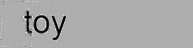

In [1437]:
show(adv_img[idx])

In [ ]:
with open(f'wm_result/{title}.pkl', 'rb') as f:
    (_, _, _, wm0_img, record_text, _, wm_adv_img, record_adv_text, record_iter, _, rgb_img) = pickle.load(f)    

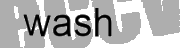

In [1426]:
show(wm0_img[idx])

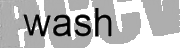

In [1427]:
show(wm_adv_img[idx])

# hyper-parameter c

In [2636]:
font_name = 'Arial'
case = 'easy'
const = '25.0'

In [2637]:
import sys

In [2638]:
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/word_image_data'
with open(f'{img_data_path}/intersect_word.pkl', 'rb') as f:
    intersect_word = pickle.load(f)
intersect_word = set(intersect_word)

def filter_word(input_img, len_x, gt_txt, target_txt):
    new_input_img, new_len_x, new_gt_txt, new_target_txt = [], [], [], []
    for i, gt in enumerate(gt_txt):
        if gt in intersect_word:
            new_input_img.append(input_img[i])
            new_len_x.append(len_x[i])
            new_gt_txt.append(gt_txt[i])
            new_target_txt.append(target_txt[i])
    return np.asarray(new_input_img), new_len_x, new_gt_txt, new_target_txt

with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
    _, input_img, len_x, gt_txt, target_txt = pickle.load(f)
input_img = np.asarray(input_img)
input_img, len_x, gt_txt, target_txt = filter_word(input_img, len_x, gt_txt, target_txt)

In [2639]:
with open(f'basic_opt_result/{font_name}-{case}-{const}.pkl', 'rb') as f:
    (opt_adv_img, adv_txt_list, adv_l2, adv_iter_list, adv_asr_list, _) = pickle.load(f)

In [2640]:
compare_mse(input_img[:opt_adv_img.shape[0]] * 255, opt_adv_img * 255)

79.45340946281361

In [2641]:
cnt = 0
for batch_asr in adv_asr_list:
    for i in batch_asr[::-1]:
        if i != -1:
            cnt += i
            break
cnt / len(input_img)

0.9767308244757253

In [2642]:
np.mean(np.array(adv_iter_list))

295.83588235294116

In [2643]:
with open(f'wm_opt_result/{font_name}-{case}-{const}.pkl', 'rb') as f:
    (adv_img, adv_txt_list, adv_l2, adv_iter_list, adv_asr_list, _) = pickle.load(f)

In [2644]:
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/word_image_data'
with open(f'{img_data_path}/intersect_word.pkl', 'rb') as f:
    intersect_word = pickle.load(f)
intersect_word = set(intersect_word)

def filter_word(input_img, len_x, gt_txt, target_txt, wm0_mask):
    new_input_img, new_len_x, new_gt_txt, new_target_txt, new_wm0_mask = [], [], [], [], []
    for i, gt in enumerate(gt_txt):
        if gt in intersect_word:
            new_input_img.append(input_img[i])
            new_len_x.append(len_x[i])
            new_gt_txt.append(gt_txt[i])
            new_target_txt.append(target_txt[i])
            new_wm0_mask.append(wm0_mask[i])
    return np.asarray(new_input_img), new_len_x, new_gt_txt, new_target_txt, np.asarray(new_wm0_mask)

with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
    _, _, len_x, gt_txt, target_txt = pickle.load(f)

title = f"{font_name}-{case}-l2-eps0.2-ieps5.0-iter1000"
with open(f'wm_result/{title}.pkl', 'rb') as f:
# with open(f'sample_images_calamari/grad-wm-{title}.pkl', 'rb') as f:
    (_, wm0_mask, _, wm0_img, _, _, _, _, _, _, _) = pickle.load(f)
input_img, len_x, gt_txt, target_txt, wm_mask_img = filter_word(wm0_img, len_x, gt_txt, target_txt, wm0_mask)

In [2645]:
compare_mse(input_img[:opt_adv_img.shape[0]] * 255, adv_img * 255)

42.28425142445993

In [2646]:
cnt = 0
for batch_asr in adv_asr_list:
    for i in batch_asr[::-1]:
        if i != -1:
            cnt += i
            break
cnt / len(input_img)

0.9767308244757253

In [2647]:
np.mean(np.array(adv_iter_list))

20.33058823529412

In [2702]:
figsize=[5, 2.5]

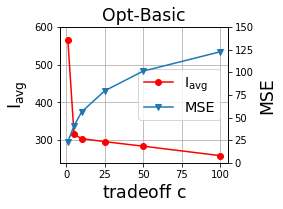

In [2804]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('mathtext', default='regular')

# time = np.array([0.5, 1, 5, 10, 25, 50, 100]) # tradeoff c
# temp = np.array([901, 565, 315, 304, 296, 284, 259]) # left y Iavg
# Swdown = np.array([353.9, 23.4, 40.8, 56.3, 79.5, 101.2, 122.5]) # right y MSE

time = np.array([1, 5, 10, 25, 50, 100])  # tradeoff c
temp = np.array([565, 315, 304, 296, 284, 259])  # left y Iavg
Swdown = np.array([23.4, 40.8, 56.3, 79.5, 101.2, 122.5])  # right y MSE

fig, ax = plt.subplots(1, 1, figsize=figsize)
lns1 = ax.plot(time, temp, '-ro', label='$\mathrm{I_{avg}}$')
ax2 = ax.twinx()

lns2 = ax2.plot(time, Swdown, '-v', label='MSE')
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='center right', fontsize='x-large')

ax.grid()
ax.set_xlabel("tradeoff $c$", fontsize='xx-large')

ax2.set_ylabel(r"MSE", fontsize='xx-large')
ax.set_ylabel(r"$\mathrm{I_{avg}}$", fontsize='xx-large')

ax.set_ylim(240, 600, auto=True)
ax2.set_ylim(0, 150, auto=True)

plt.title('Opt-Basic', fontsize='xx-large')
plt.savefig('result_pic/tradeoff-opt-basic.pdf',
            quality=100,
            bbox_inches='tight')

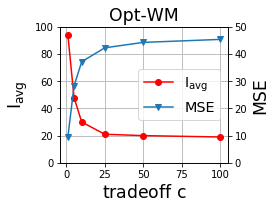

In [2797]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('mathtext', default='regular')

# time = np.array([0.5, 1, 5, 10, 25, 50, 100]) # tradeoff c
# temp = np.array([488, 94, 48, 30, 21, 20, 19]) # right y Iavg
# Swdown = np.array([50.1, 9.5, 28.3, 37.2, 42.3, 44.3, 45.4]) # left y MSE

time = np.array([1, 5, 10, 25, 50, 100])  # tradeoff c
temp = np.array([94, 48, 30, 21, 20, 19])  # right y Iavg
Swdown = np.array([9.5, 28.3, 37.2, 42.3, 44.3, 45.4])  # left y MSE

fig, ax = plt.subplots(1, 1, figsize=figsize)

lns1 = ax.plot(time, temp, '-ro', label='$\mathrm{I_{avg}}$')
ax2 = ax.twinx()

lns2 = ax2.plot(time, Swdown, '-v', label='MSE')
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='center right', fontsize='x-large')

ax.grid()
ax.set_xlabel("tradeoff $c$", fontsize='xx-large')
ax2.set_ylabel(r"MSE", fontsize='xx-large')
ax.set_ylabel(r"$\mathrm{I_{avg}}$", fontsize='xx-large')

ax.set_ylim(0, 100)
ax2.set_ylim(0, 50, auto=True)

plt.title('Opt-WM', fontsize='xx-large')
plt.savefig('result_pic/tradeoff-opt-wm.pdf', quality=100, bbox_inches='tight')

# step size $\alpha$

In [2769]:
case = 'easy'
nb_iter = 1000
font_name = 'Arial'
# word image data
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/word_image_data'

In [2770]:
title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"

In [2778]:
with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
    _, raw_input_img, raw_len_x, raw_gt_txt, raw_target_txt = pickle.load(f)
    raw_input_img = np.asarray(raw_input_img)
for eps_iter in [0.5, 1.0, 2.0, 5.0, 10.0]:
    title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
    with open(f'attack_result/{title}.pkl', 'rb') as f:
        adv_img, record_adv_text, record_iter, (duration, total_iter) = pickle.load(f)
    input_img, adv_img, gt_txt, target_txt, record_adv_text, record_iter = \
        filter_word(raw_input_img, adv_img, raw_gt_txt, raw_target_txt, record_adv_text, record_iter)
    input_img = (255 * cvt2raw(input_img)).astype('uint8')
    adv_img = (255 * cvt2raw(adv_img)).astype('uint8')
    avg_success_iter = np.mean(record_iter[record_iter != 0]) 
    print(eps_iter, compare_mse(input_img, adv_img), avg_success_iter)

0.5 26.09771206162841 506.0
1.0 29.047283792996176 253.0
2.0 29.442035787415424 128.0
5.0 29.805648222847047 51.0
10.0 30.40336056356267 26.0


In [2779]:
with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
    _, input_img, _, gt_txt, target_txt = pickle.load(f)
input_img = np.asarray(input_img)
for eps_iter in [0.5, 1.0, 2.0, 5.0, 10.0]:
    title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
    with open(f'wm_result/{title}.pkl', 'rb') as f:
        (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, adv_img, record_adv_text, record_iter, (duration, total_iter), rgb_img) = pickle.load(f)
    input_img, adv_img, gt_txt, target_txt, record_adv_text, record_iter, wm0_img, record_text, rgb_img = \
    filter_word_wm(input_img, adv_img, gt_txt, target_txt, record_adv_text, record_iter, wm0_img, record_text, rgb_img)

    input_img = (255 * cvt2raw(wm0_img)).astype('uint8')
    adv_img = (255 * cvt2raw(adv_img)).astype('uint8')
    avg_success_iter = np.mean(record_iter[record_iter != 0]) 
    print(eps_iter, compare_mse(input_img, adv_img), avg_success_iter)

0.5 8.615789594785213 93.0
1.0 8.84350020143895 46.0
2.0 8.969691004560161 23.0
5.0 9.535266452625379 13.0
10.0 9.860294677645586 5.0


In [2807]:
figsize=[3, 2.5]

In [2934]:
figsize=[5, 2.5]


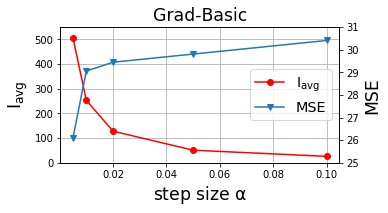

In [2935]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

time = np.array([0.005, 0.01, 0.02, 0.05, 0.1])  # tradeoff c
temp = np.array([506, 253, 128, 51, 26])  # left y Iavg
Swdown = np.array([26.10, 29.05, 29.44, 29.80, 30.40])  # right y MSE

fig, ax = plt.subplots(1, 1, figsize=figsize)
lns1 = ax.plot(time, temp, '-ro', label='$\mathrm{I_{avg}}$')
ax2 = ax.twinx()

lns2 = ax2.plot(time, Swdown, '-v', label='MSE')
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='center right', fontsize='x-large')

ax.grid()
ax.set_xlabel(r"step size $\alpha$", fontsize='xx-large')

ax2.set_ylabel(r"MSE", fontsize='xx-large')
ax.set_ylabel(r"$\mathrm{I_{avg}}$", fontsize='xx-large')

ax.set_ylim(0, 550)
ax2.set_ylim(25, 31, auto=True)

# ax2.legend(loc='best', fontsize='xx-large')# Iavg
plt.title('Grad-Basic', fontsize='xx-large')
# plt.tick_params(labelsize=fsize)
plt.savefig('result_pic/stepsize-grad-basic.pdf',
            quality=100,
            bbox_inches='tight')

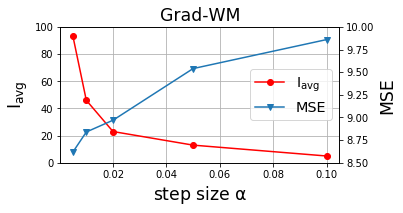

In [2936]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('mathtext', default='regular')

time = np.array([0.005, 0.01, 0.02, 0.05, 0.1])  # tradeoff c
temp = np.array([93, 46, 23, 13, 5])  # left y Iavg
Swdown = np.array([8.62, 8.84, 8.97, 9.54, 9.86])  # right y MSE

fig, ax = plt.subplots(1, 1, figsize=figsize)
lns1 = ax.plot(time, temp, '-ro', label='$\mathrm{I_{avg}}$')
ax2 = ax.twinx()

lns2 = ax2.plot(time, Swdown, '-v', label='MSE')
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='center right', fontsize='x-large')

ax.grid()
ax.set_xlabel(r"step size $\alpha$", fontsize='xx-large')
ax2.set_ylabel(r"MSE", fontsize='xx-large')
ax.set_ylabel(r"$\mathrm{I_{avg}}$", fontsize='xx-large')

ax.set_ylim(0, 100)
ax2.set_ylim(8.5, 10, auto=True)

plt.title('Grad-WM', fontsize='xx-large')
plt.savefig('result_pic/stepsize-grad-wm.pdf', quality=100, bbox_inches='tight')

# slow start

In [2843]:
with open('wm_result/Arial-replace-full-word-mse.pkl', 'rb') as f:
    record_mse, record_mse_plus = pickle.load(f)

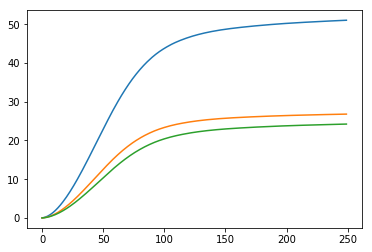

In [2844]:
# x = np.arange(len(record_mse))
iterations = 250
x = np.arange(iterations)
plt.plot(x, record_mse[:iterations])
plt.plot(x, record_mse_plus[:iterations])
plt.plot(x, np.array(record_mse[:iterations]) - np.array(record_mse_plus[:iterations]))

In [2845]:
with open('attack_result/Arial-replace-full-word-mse.pkl', 'rb') as f:
    record_mse, record_mse_plus = pickle.load(f)

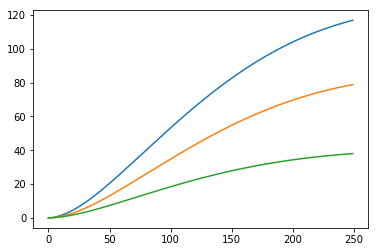

In [2846]:
# x = np.arange(len(record_mse))
iterations = 250
x = np.arange(iterations)
plt.plot(x, record_mse[:iterations])
plt.plot(x, record_mse_plus[:iterations])
plt.plot(x, np.array(record_mse[:iterations]) - np.array(record_mse_plus[:iterations]))

In [2907]:
c_b = [10.5, 59, 14.0, 74, 17.0, 70, 11.6, 50, 3.2, 21, 25.4, 266, 30.3, 313, 36.7, 321, 25.4, 309, 13.6, 43 ]
c_w = [2.8, 30, 3.6, 18, 4.3, 27, 3.6, 21, 0.7, 8, 16.7, 116, 20.1, 96, 20.4, 95, 31.1, 29, 3.2, 13]

In [2908]:
g_b =  [27.4, 43, 32.8, 99, 37.3, 104, 22.1, 83, 17.3, 55, 52.0, 292, 59.4, 318, 67.5, 328, 41.6, 337, 45.0, 169]
g_w =  [7.8, 15, 8.9, 33, 9.8, 30, 5.1, 39, 3.5, 21, 31.6, 30, 35.1, 32, 38.3, 37, 21.7, 12, 16.2, 9]

In [2909]:
h_b =[27.0, 51, 33.6, 113, 38.6, 113, 23.0, 70, 16.7, 43, 52.1, 301, 60.2, 328, 68.2, 340, 47.1, 321, 45.0, 178] 
h_w =[8.4, 9, 10.0, 52, 11.2, 52, 6.3, 23, 3.7, 19, 33.3, 31, 37.0, 42, 38.8, 53, 25.1, 13, 16.5, 9]

In [2910]:
t_b = [26.4, 62, 31.5, 85, 35.8, 109, 20.3, 98, 17.2, 68, 49.9, 294, 56.1, 324, 61.6, 345, 41.7, 314, 44.3, 172]
t_w = [7.3, 15, 8.3, 20, 9.3, 34, 4.5, 7, 3.4, 21, 30.3, 22, 33.9, 26, 35.9, 36, 19.2, 11, 15.4, 8]

In [2911]:
a_b = [29.8, 51, 36.7, 73, 42.5, 66, 24.3, 88, 19.2, 59, 56.3, 304, 65.3, 327, 73.8, 341, 48.3, 324, 51.0, 176] 
a_w = [9.4, 13, 11.1, 14, 12.7, 25, 6.2, 33, 4.4, 20, 37.2, 30, 40.4, 45, 43.6, 50, 25.4, 16, 19.4, 10]

In [2928]:
def avg(b, w, t):
    if t=="mse":
        mse_idx = list(range(10, 20, 2))
        b = np.array(b)[mse_idx]
        w = np.array(w)[mse_idx]
    elif t=='iter':
        iter_idx = list(range(11, 20, 2))
        b = np.array(b)[iter_idx]
        w = np.array(w)[iter_idx]
    elif t=='replace_mse':
        mse_idx = [0, 2, 4, 10, 12, 14]
        b = np.array(b)[mse_idx]
        w = np.array(w)[mse_idx]
    elif t=='replace_iter':
        iter_idx = [1, 3, 5, 11, 13, 15]
        b = np.array(b)[iter_idx]
        w = np.array(w)[iter_idx]
    elif t=='insert_mse':
        mse_idx = [6, 8, 16, 18]
        b = np.array(b)[mse_idx]
        w = np.array(w)[mse_idx]
    elif t=='insert_iter':
        iter_idx = [7, 9, 17, 19]
        b = np.array(b)[iter_idx]
        w = np.array(w)[iter_idx]
    return np.mean(np.array(w) / np.array(b))

In [2929]:
a = [avg(b, w, 'mse') for b, w in zip([c_b, g_b, h_b, t_b, a_b], [c_w, g_w, h_w, t_w, a_w])]

In [2930]:
np.mean(np.array(a))

0.5634059535245182

In [2883]:
1 - 15.47/55.82

0.722859190254389

In [2894]:
c_b=[50.6, 31.1, 0.9, 235, 5.8, 40.5, 1.0, 153, 7.0, 39.7, 1.0, 113]
c_w=[12.9, 37.0, 1.0, 51, 3.4, 42.8, 1.0, 60, 8.7, 38.7, 1.0, 57]
g_b=[118.6, 27.4, 0.9, 326, 14.6, 36.5, 1.0, 239, 21.3, 34.9, 1.0, 203]
g_w=[35.4, 32.6, 1.0, 131, 5.2, 41.0, 1.0, 90, 9.2, 38.5, 1.0, 81]
h_b=[124.0, 27.2, 0.9, 254, 14.2, 36.6, 1.0, 238, 22.5, 34.6, 1.0, 233]
h_w=[40.0, 32.1, 1.0, 124, 5.4, 40.8, 1.0, 91, 11.8, 37.4, 1.0, 96]
t_b=[114.4, 27.5, 0.9, 291, 13.2, 36.9, 1.0, 201, 17.4, 35.7, 1.0, 164]
t_w=[34.8, 32.7, 1.0, 160, 4.5, 41.6, 1.0, 79, 6.7, 39.9, 1.0, 74]
a_b=[133.9, 26.9, 0.9, 222, 15.8, 36.1, 1.0, 273, 23.2, 34.5, 1.0, 242]
a_w=[44.6, 31.6, 1.0, 138, 6.1, 40.3, 1.0, 98, 12.0, 37.3, 1.0, 98]

In [2895]:
def avg(b, w, t):
    if t=="mse":
        mse_idx = list(range(0, 12, 4))
        b = np.array(b)[mse_idx]
        w = np.array(w)[mse_idx]
    elif t=='iter':
        iter_idx = list(range(1, 12, 4))
        b = np.array(b)[iter_idx]
        w = np.array(w)[iter_idx]
    elif t=='replace_mse':
        mse_idx = [0, 2, 4, 10, 12, 14]
        b = np.array(b)[mse_idx]
        w = np.array(w)[mse_idx]
    elif t=='replace_iter':
        iter_idx = [1, 3, 5, 11, 13, 15]
        b = np.array(b)[iter_idx]
        w = np.array(w)[iter_idx]
    elif t=='insert_mse':
        mse_idx = [6, 8, 16, 18]
        b = np.array(b)[mse_idx]
        w = np.array(w)[mse_idx]
    elif t=='insert_iter':
        iter_idx = [7, 9, 17, 19]
        b = np.array(b)[iter_idx]
        w = np.array(w)[iter_idx]
    return np.mean(np.array(w) / np.array(b))

In [2896]:
a = [avg(b, w, 'mse') for b, w in zip([c_b, g_b, h_b, t_b, a_b], [c_w, g_w, h_w, t_w, a_w])]

In [2900]:
1- np.mean(np.array(a))

0.555703521558971

In [2904]:
# w = [48.5, 156.6, 146.8, 145.9, 153.5]
# b = [2.8, 7.8, 8.4, 7.3, 9.4]
w = [186, 546, 474, 515, 463]
b = [30, 15, 8, 15, 13]

In [2905]:
np.mean(np.array(w) / np.array(b))

34.35974358974359

# WM negative

In [2937]:
font_name = 'Arial'
case = 'easy'
pert_type = '2'
eps = 0.2
eps_iter = 5.0
nb_iter = 1000
title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}-negative"
with open(f'wm_result/{title}.pkl', 'rb') as f:
    (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, adv_img, record_adv_text, record_iter, (duration, i), rgb_img) = pickle.load(f)

In [2976]:
for font_name in fonts[:5]:
    for case in cases[:1]:
        with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
            img_list, input_img, len_x, gt_txt, target_txt = pickle.load(f)
        input_img = np.asarray(input_img)
        title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}-negative"
        with open(f'wm_result/{title}.pkl', 'rb') as f:
            (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, adv_img, record_adv_text, record_iter, (duration, i), rgb_img) = pickle.load(f)        
        print(f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter} {len(adv_img)} examples")
        
        input_img = (255 * cvt2raw(wm0_img)).astype('uint8')
        adv_img = (255 * cvt2raw(adv_img)).astype('uint8')
        
        cvt2Image(adv_img[target_txt.index('ports')]).save(f'result_pic/negative-{font_name}-ports.jpg')
        
        mse, psnr, ssim = pert_eval(adv_img, input_img)
        print(f"mse-{mse:.3f} psnr-{psnr:.3f} ssim-{ssim:.3f}")
        wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)
        print(f"wm_mse-{wm_mse:.3f} bg_mse-{bg_mse:.3f} text_mse-{text_mse:.3f}")
        t_asr, u_asr, fail_r = asr_eval(record_adv_text, target_txt, gt_txt)
        print(f"t_asr-{100*t_asr:.3f} u_asr-{100*u_asr:.3f} fail_r-{100*fail_r:.3f}")
        avg_success_iter, avg_iter_time = iter_eval(record_iter, duration)
        print(f"avg_success_iter-{avg_success_iter:.3f} avg_iter_time-{avg_iter_time:.3f}")
        print("-" * 60)

Courier-easy-l2-eps0.2-ieps5.0-iter1000 3532 examples
mse-17.820 psnr-35.622 ssim-0.995
wm_mse-8.899 bg_mse-8.749 text_mse-9.071
t_asr-97.055 u_asr-98.216 fail_r-1.784
avg_success_iter-42.438 avg_iter_time-5.815
------------------------------------------------------------
Georgia-easy-l2-eps0.2-ieps5.0-iter1000 4868 examples
mse-31.652 psnr-33.127 ssim-0.990
wm_mse-16.199 bg_mse-17.952 text_mse-13.700
t_asr-94.207 u_asr-95.357 fail_r-4.643
avg_success_iter-86.183 avg_iter_time-7.157
------------------------------------------------------------
Helvetica-easy-l2-eps0.2-ieps5.0-iter1000 4842 examples
mse-40.760 psnr-32.028 ssim-0.987
wm_mse-20.683 bg_mse-22.162 text_mse-18.598
t_asr-90.789 u_asr-92.255 fail_r-7.745
avg_success_iter-88.412 avg_iter_time-6.079
------------------------------------------------------------
times-easy-l2-eps0.2-ieps5.0-iter1000 4887 examples
mse-32.687 psnr-32.987 ssim-0.989
wm_mse-16.661 bg_mse-18.180 text_mse-14.507
t_asr-93.513 u_asr-94.516 fail_r-5.484
avg_

# WM positive

In [2994]:
for font_name in fonts[:5]:
    for case in cases[:1]:
        with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
            img_list, input_img, len_x, gt_txt, target_txt = pickle.load(f)
        input_img = np.asarray(input_img)
        title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}-positive"
        with open(f'wm_result/{title}.pkl', 'rb') as f:
            (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, adv_img, record_adv_text, record_iter, (duration, i), rgb_img) = pickle.load(f)        
        print(f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter} {len(adv_img)} examples")
        
        input_img = (255 * cvt2raw(wm0_img)).astype('uint8')
        adv_img = (255 * cvt2raw(adv_img)).astype('uint8')
        
        cvt2Image(adv_img[target_txt.index('ports')]).save(f'result_pic/positive-{font_name}-ports.jpg')
        
        mse, psnr, ssim = pert_eval(adv_img, input_img)
        print(f"mse-{mse:.3f} psnr-{psnr:.3f} ssim-{ssim:.3f}")
        wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)
        print(f"wm_mse-{wm_mse:.3f} bg_mse-{bg_mse:.3f} text_mse-{text_mse:.3f}")
        t_asr, u_asr, fail_r = asr_eval(record_adv_text, target_txt, gt_txt)
        print(f"t_asr-{100*t_asr:.3f} u_asr-{100*u_asr:.3f} fail_r-{100*fail_r:.3f}")
        avg_success_iter, avg_iter_time = iter_eval(record_iter, duration)
        print(f"avg_success_iter-{avg_success_iter:.3f} avg_iter_time-{avg_iter_time:.3f}")
        print("-" * 60)

Courier-easy-l2-eps0.2-ieps5.0-iter1000 3532 examples
mse-16.394 psnr-35.984 ssim-0.996
wm_mse-8.846 bg_mse-16.394 text_mse-0.000
t_asr-97.027 u_asr-98.131 fail_r-1.869
avg_success_iter-41.403 avg_iter_time-6.516
------------------------------------------------------------
Georgia-easy-l2-eps0.2-ieps5.0-iter1000 4868 examples
mse-28.760 psnr-33.543 ssim-0.992
wm_mse-17.133 bg_mse-28.760 text_mse-0.000
t_asr-94.885 u_asr-96.302 fail_r-3.698
avg_success_iter-73.382 avg_iter_time-6.799
------------------------------------------------------------
Helvetica-easy-l2-eps0.2-ieps5.0-iter1000 4842 examples
mse-36.515 psnr-32.506 ssim-0.990
wm_mse-21.745 bg_mse-36.515 text_mse-0.000
t_asr-91.822 u_asr-93.763 fail_r-6.237
avg_success_iter-77.632 avg_iter_time-7.475
------------------------------------------------------------
times-easy-l2-eps0.2-ieps5.0-iter1000 4887 examples
mse-29.839 psnr-33.383 ssim-0.991
wm_mse-17.746 bg_mse-29.839 text_mse-0.000
t_asr-94.271 u_asr-95.723 fail_r-4.277
avg_su

# Text Edge

In [2975]:
for font_name in fonts[:5]:
    for case in cases[:1]:
        with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
            img_list, input_img, len_x, gt_txt, target_txt = pickle.load(f)
        input_img = np.asarray(input_img)
        title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}-text-edge"
        with open(f'wm_result/{title}.pkl', 'rb') as f:
            (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, adv_img, record_adv_text, record_iter, (duration, i), rgb_img) = pickle.load(f)        
        print(f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter} {len(adv_img)} examples")
        
        input_img = (255 * cvt2raw(input_img)).astype('uint8')
        adv_img = (255 * cvt2raw(adv_img)).astype('uint8')
        
        cvt2Image(adv_img[target_txt.index('ports')]).save(f'result_pic/text-edge-{font_name}-ports.jpg')
        
        mse, psnr, ssim = pert_eval(adv_img, input_img)
        print(f"mse-{mse:.3f} psnr-{psnr:.3f} ssim-{ssim:.3f}")
        wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)
        print(f"wm_mse-{wm_mse:.3f} bg_mse-{bg_mse:.3f} text_mse-{text_mse:.3f}")
        t_asr, u_asr, fail_r = asr_eval(record_adv_text, target_txt, gt_txt)
        print(f"t_asr-{100*t_asr:.3f} u_asr-{100*u_asr:.3f} fail_r-{100*fail_r:.3f}")
        avg_success_iter, avg_iter_time = iter_eval(record_iter, duration)
        print(f"avg_success_iter-{avg_success_iter:.3f} avg_iter_time-{avg_iter_time:.3f}")
        print("-" * 60)

Courier-easy-l2-eps0.2-ieps5.0-iter1000 3532 examples
mse-14.305 psnr-36.576 ssim-0.995
wm_mse-5.570 bg_mse-8.962 text_mse-5.343
t_asr-98.839 u_asr-99.802 fail_r-0.198
avg_success_iter-57.599 avg_iter_time-8.647
------------------------------------------------------------
Georgia-easy-l2-eps0.2-ieps5.0-iter1000 4868 examples
mse-38.791 psnr-32.243 ssim-0.991
wm_mse-12.617 bg_mse-27.612 text_mse-11.179
t_asr-94.577 u_asr-96.343 fail_r-3.657
avg_success_iter-143.763 avg_iter_time-8.814
------------------------------------------------------------
Helvetica-easy-l2-eps0.2-ieps5.0-iter1000 4842 examples
mse-38.131 psnr-32.318 ssim-0.992
wm_mse-12.528 bg_mse-27.158 text_mse-10.973
t_asr-95.622 u_asr-97.233 fail_r-2.767
avg_success_iter-137.059 avg_iter_time-8.704
------------------------------------------------------------
times-easy-l2-eps0.2-ieps5.0-iter1000 4887 examples
mse-37.051 psnr-32.443 ssim-0.991
wm_mse-12.218 bg_mse-26.133 text_mse-10.917
t_asr-96.255 u_asr-97.626 fail_r-2.374
av

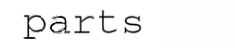

# initial grayscale $beta$

In [3011]:
grayscales = [179, 204, 230, 242]
case = 'easy'
with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
    img_list, input_img, len_x, gt_txt, target_txt = pickle.load(f)

In [2978]:
input_img = np.asarray(input_img)
for gray in grayscales:
    title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}-gray{gray}"
    with open(f'wm_result/{title}.pkl', 'rb') as f:
        (pos, wm_mask, text_mask, wm0_img, record_text, accuracy, adv_img, record_adv_text, record_iter, (duration, i), rgb_img) = pickle.load(f)
    print(f"{gray}-{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter} {len(adv_img)} examples")
    input_img = (255 * cvt2raw(wm0_img)).astype('uint8')
    adv_img = (255 * cvt2raw(adv_img)).astype('uint8')

    cvt2Image(adv_img[target_txt.index('ports')]).save(f'result_pic/grayscale-{gray}-ports.jpg')

    mse, psnr, ssim = pert_eval(adv_img, input_img)
    print(f"mse-{mse:.3f} psnr-{psnr:.3f} ssim-{ssim:.3f}")
    wm_mse, bg_mse, text_mse = wm_pert_eval(adv_img, input_img)
    print(f"wm_mse-{wm_mse:.3f} bg_mse-{bg_mse:.3f} text_mse-{text_mse:.3f}")
    t_asr, u_asr, fail_r = asr_eval(record_adv_text, target_txt, gt_txt)
    print(f"t_asr-{100*t_asr:.3f} u_asr-{100*u_asr:.3f} fail_r-{100*fail_r:.3f}")
    avg_success_iter, avg_iter_time = iter_eval(record_iter, duration)
    print(f"avg_success_iter-{avg_success_iter:.3f} avg_iter_time-{avg_iter_time:.3f}")
    print("-" * 60)

179-Arial-easy-l2-eps0.2-ieps5.0-iter1000 4824 examples
mse-15.807 psnr-36.142 ssim-0.995
wm_mse-8.903 bg_mse-13.136 text_mse-2.671
t_asr-98.238 u_asr-98.487 fail_r-1.513
avg_success_iter-46.083 avg_iter_time-6.780
------------------------------------------------------------
204-Arial-easy-l2-eps0.2-ieps5.0-iter1000 4824 examples
mse-23.109 psnr-34.493 ssim-0.991
wm_mse-10.129 bg_mse-16.362 text_mse-6.747
t_asr-97.823 u_asr-98.051 fail_r-1.949
avg_success_iter-61.253 avg_iter_time-7.603
------------------------------------------------------------
230-Arial-easy-l2-eps0.2-ieps5.0-iter1000 4824 examples
mse-30.153 psnr-33.338 ssim-0.981
wm_mse-11.407 bg_mse-19.718 text_mse-10.435
t_asr-95.854 u_asr-96.310 fail_r-3.690
avg_success_iter-86.054 avg_iter_time-6.108
------------------------------------------------------------
242-Arial-easy-l2-eps0.2-ieps5.0-iter1000 4824 examples
mse-34.400 psnr-32.765 ssim-0.971
wm_mse-12.637 bg_mse-22.954 text_mse-11.446
t_asr-94.133 u_asr-94.735 fail_r-5.

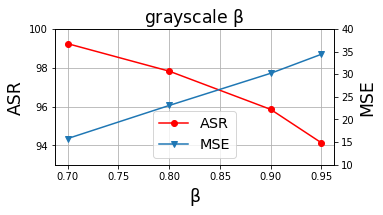

In [2993]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

time = np.array([0.95, 0.90, 0.80, 0.70])  # tradeoff c
# temp = np.array([107, 86, 61, 46])  # left y Iavg
Swdown = np.array([34.4, 30.2, 23.1, 15.8])  # right y MSE
temp = np.array([94.133, 95.854, 97.823, 99.238]) # left y Iavg


fig, ax = plt.subplots(1, 1, figsize=figsize)
# lns1 = ax.plot(time, temp, '-ro', label='$\mathrm{I_{avg}}$')
lns1 = ax.plot(time, temp, '-ro', label='ASR')
ax2 = ax.twinx()

lns2 = ax2.plot(time, Swdown, '-v', label='MSE')
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='lower center', fontsize='x-large')

ax.grid()
ax.set_xlabel(r"$\beta$", fontsize='xx-large')

ax2.set_ylabel(r"MSE", fontsize='xx-large')
# ax.set_ylabel(r"$\mathrm{I_{avg}}$", fontsize='xx-large')
ax.set_ylabel(r"ASR", fontsize='xx-large')

ax.set_ylim(93, 100, auto=True)
ax2.set_ylim(10, 40, auto=True)

plt.title(r'grayscale $\beta$', fontsize='xx-large')
plt.savefig('result_pic/grayscale.pdf',
            quality=100,
            bbox_inches='tight')